<a href="https://colab.research.google.com/github/pratheeshsailor/-LoanTap-Logistic-Regression/blob/main/LoanTap_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Case: LoanTap Logistic Regression

LoanTap is an online platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.

The data science team at LoanTap is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

LoanTap deploys formal credit to salaried individuals and businesses 4 main financial instruments:

* Personal Loan
* EMI Free Loan
* Personal Overdraft
* Advance Salary Loan
This case study will focus on the underwriting process behind Personal Loan only

Problem Statement:

Given a set of attributes for an Individual, determine if a credit line should be extended to them. If so, what should the repayment terms be in business recommendations?

In [397]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

In [219]:
df = pd.read_csv("logistic_regression.csv")

In [220]:
df.head(4)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"


In [221]:
# Shape of the dataset
print("No. of rows : ",df.shape[0])
print("No. of columns : ",df.shape[1])

No. of rows :  396030
No. of columns :  27


In [222]:
(df.isna().sum() / df.shape[0] )*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

* As we can see, there is an imbalance in the data.

In [223]:
# unique values in the dataset
for col in df:
    print(f'Number of unique values in the {col} column:',df[col].nunique())

Number of unique values in the loan_amnt column: 1397
Number of unique values in the term column: 2
Number of unique values in the int_rate column: 566
Number of unique values in the installment column: 55706
Number of unique values in the grade column: 7
Number of unique values in the sub_grade column: 35
Number of unique values in the emp_title column: 173105
Number of unique values in the emp_length column: 11
Number of unique values in the home_ownership column: 6
Number of unique values in the annual_inc column: 27197
Number of unique values in the verification_status column: 3
Number of unique values in the issue_d column: 115
Number of unique values in the loan_status column: 2
Number of unique values in the purpose column: 14
Number of unique values in the title column: 48817
Number of unique values in the dti column: 4262
Number of unique values in the earliest_cr_line column: 684
Number of unique values in the open_acc column: 61
Number of unique values in the pub_rec column:

In [224]:
columns = df.columns
columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [225]:
# Checking the distribution of the outcome labels
df.loan_status.value_counts(normalize=True)*100

Fully Paid     80.387092
Charged Off    19.612908
Name: loan_status, dtype: float64


* 80% belongs to the class 0 : which is loan fully paid.
* 20% belongs to the class 1 : which were charged off.

In [226]:
df.initial_list_status.value_counts(normalize=True)*100

f    60.113123
w    39.886877
Name: initial_list_status, dtype: float64

* 60% initial list_status belongs to whole loans(w)
* 40% initial list_status belongs to fractional loans(f)

In [227]:
df.application_type.value_counts(normalize=True)*100

INDIVIDUAL    99.820468
JOINT          0.107315
DIRECT_PAY     0.072217
Name: application_type, dtype: float64

* Maximum 99% are loans belongs to INDIVIDUAL

In [228]:
df.term.value_counts(normalize=True)*100

 36 months    76.258112
 60 months    23.741888
Name: term, dtype: float64

* 76% loans periods are 36 months
* 24% loans periods are 60 months

In [229]:
df.grade.value_counts(normalize=True)*100

B    29.295255
C    26.762366
A    16.207611
D    16.040199
E     7.950913
F     2.972502
G     0.771154
Name: grade, dtype: float64

* the grade thats given based on loans values
* 16% are A grade, 29% are B grade

In [230]:
# The home ownership status provided by the borrower during registration or obtained from the credit report.
df.home_ownership.value_counts(normalize=True)*100

MORTGAGE    50.084085
RENT        40.347953
OWN          9.531096
OTHER        0.028281
NONE         0.007828
ANY          0.000758
Name: home_ownership, dtype: float64

* 50% loans belongs to mortgage
* 40% loans belongs to rent


In [231]:
df.verification_status.value_counts(normalize=True)*100

Verified           35.240512
Source Verified    33.175517
Not Verified       31.583971
Name: verification_status, dtype: float64

* 35% loans status are verified
* 33% loans status are in process

In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [233]:
for column in columns:
    print(f"Column: {column}")
    print(df[column].value_counts())
    print('----------------------------------')

Column: loan_amnt
10000.0    27668
12000.0    21366
15000.0    19903
20000.0    18969
35000.0    14576
           ...  
36225.0        1
950.0          1
37800.0        1
30050.0        1
725.0          1
Name: loan_amnt, Length: 1397, dtype: int64
----------------------------------
Column: term
 36 months    302005
 60 months     94025
Name: term, dtype: int64
----------------------------------
Column: int_rate
10.99    12411
12.99     9632
15.61     9350
11.99     8582
8.90      8019
         ...  
14.28        1
18.72        1
18.36        1
30.84        1
24.59        1
Name: int_rate, Length: 566, dtype: int64
----------------------------------
Column: installment
327.34     968
332.10     791
491.01     736
336.90     686
392.81     683
          ... 
364.37       1
1015.29      1
398.04       1
544.94       1
572.44       1
Name: installment, Length: 55706, dtype: int64
----------------------------------
Column: grade
B    116018
C    105987
A     64187
D     63524
E     31488
F

In [234]:
# Statistical summary of the dataset
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,NaN,NaN,NaN,14113.888089,8357.441341,500.0,8000.0,12000.0,20000.0,40000.0
term,396030,2,36 months,302005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,396030.0,NaN,NaN,NaN,13.6394,4.472157,5.32,10.49,13.33,16.49,30.99
installment,396030.0,NaN,NaN,NaN,431.849698,250.72779,16.08,250.33,375.43,567.3,1533.81
grade,396030,7,B,116018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,396030,35,B3,26655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_title,373103,173105,Teacher,4389,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,377729,11,10+ years,126041,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,396030,6,MORTGAGE,198348,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,396030.0,NaN,NaN,NaN,74203.175798,61637.621158,0.0,45000.0,64000.0,90000.0,8706582.0


* Loan Amount, Installments, Annual Income , revol_bal : all these columns have large differnece in mean and median . That means outliers are present in the data.

In [235]:
df['title'].value_counts()[:20]

Debt consolidation           152472
Credit card refinancing       51487
Home improvement              15264
Other                         12930
Debt Consolidation            11608
Major purchase                 4769
Consolidation                  3852
debt consolidation             3547
Business                       2949
Debt Consolidation Loan        2864
Medical expenses               2742
Car financing                  2139
Credit Card Consolidation      1775
Vacation                       1717
Moving and relocation          1689
consolidation                  1595
Personal Loan                  1591
Consolidation Loan             1299
Home Improvement               1268
Home buying                    1183
Name: title, dtype: int64

In [236]:
# some issues in title(Looks like it was filled manually and needs some fixing)
df['title']=df.title.str.lower()
df['title'].value_counts()[:20]

debt consolidation           168108
credit card refinancing       51781
home improvement              17117
other                         12993
consolidation                  5583
major purchase                 4998
debt consolidation loan        3513
business                       3017
medical expenses               2820
credit card consolidation      2638
personal loan                  2460
car financing                  2160
credit card payoff             1904
consolidation loan             1887
vacation                       1866
credit card refinance          1832
moving and relocation          1693
consolidate                    1528
personal                       1465
home buying                    1196
Name: title, dtype: int64

In [237]:
df.groupby(by='loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


<Axes: xlabel='loan_status', ylabel='loan_amnt'>

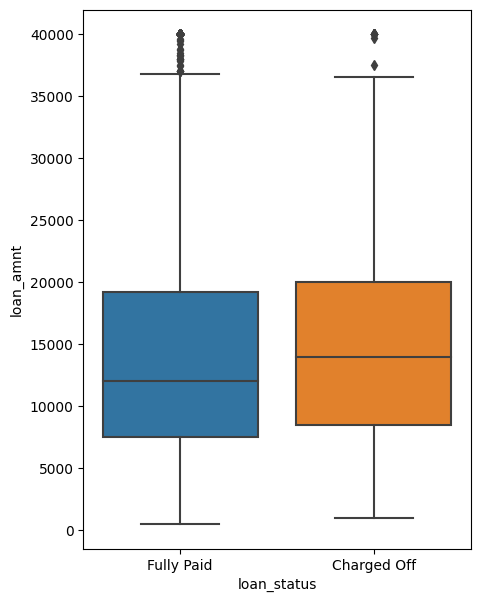

In [238]:
plt.figure(figsize=(5,7))
sns.boxplot(y=df["loan_amnt"],
            x=df["loan_status"])

<Axes: xlabel='loan_amnt', ylabel='Count'>

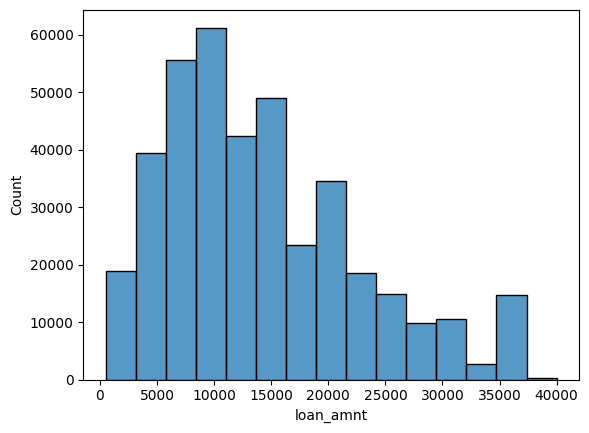

In [239]:
sns.histplot(df["loan_amnt"],bins = 15)

* for loan status Charged_off, the mean and median of loan_amount is higher than fully paid.
* also the distribution of loan_amnt is right skewed, which says it has outlier presence.

In [240]:
df.loc[(df.home_ownership == 'ANY') | (df.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'
df.home_ownership.value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: home_ownership, dtype: int64

In [241]:
pd.crosstab(index=df["term"],
            columns=df["loan_status"], normalize="index" , margins  = True
           ) * 100

loan_status,Charged Off,Fully Paid
term,,
36 months,15.774573,84.225427
60 months,31.941505,68.058495
All,19.612908,80.387092


<Axes: xlabel='term'>

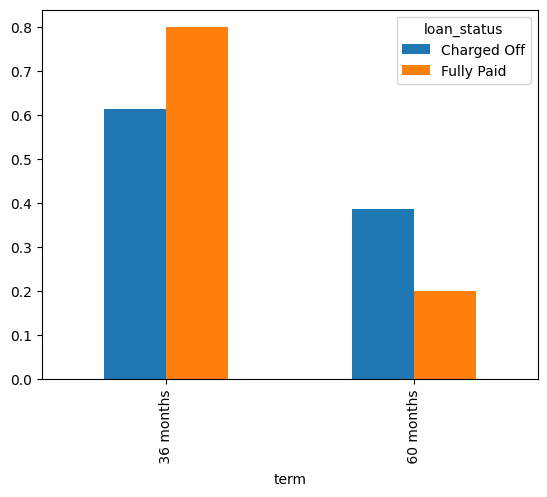

In [242]:
pd.crosstab(index=df["term"],
            columns =df["loan_status"], normalize="columns"
           ).plot(kind = "bar")

In [243]:
df.groupby(by = "loan_status")["int_rate"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15.882587,4.388135,5.32,12.99,15.61,18.64,30.99
Fully Paid,318357.0,13.092105,4.319105,5.32,9.91,12.99,15.61,30.99


<Axes: xlabel='int_rate', ylabel='Count'>

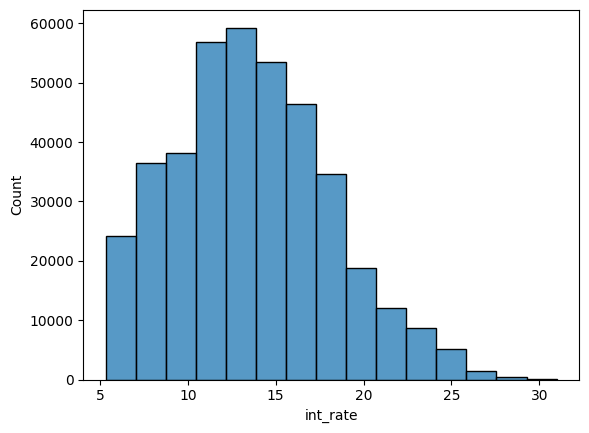

In [244]:
sns.histplot(df["int_rate"],bins = 15)

<Axes: xlabel='int_rate', ylabel='loan_status'>

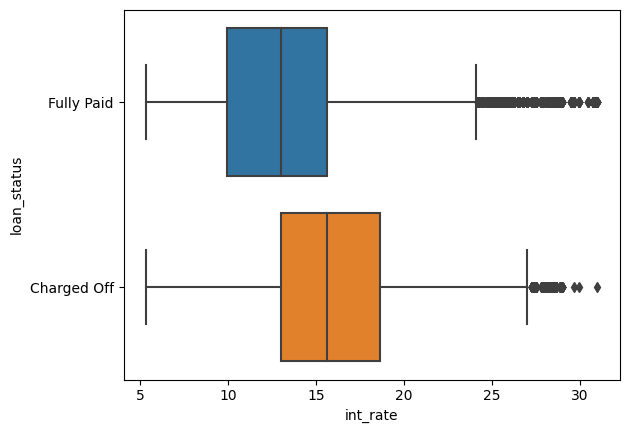

In [245]:
sns.boxplot(x=df["int_rate"],
            y=df["loan_status"])

In [246]:
df[df["loan_status"] == "Charged Off"]["int_rate"].median(),df[df["loan_status"] == "Charged Off"]["int_rate"].mean()

(15.61, 15.882587256833133)

In [247]:
df[df["loan_status"] == "Fully Paid"]["int_rate"].median(),df[df["loan_status"] == "Fully Paid"]["int_rate"].mean()

(12.99, 13.092105403682032)

* for loan status Charged_off, the mean and median of interest_rate is higher than fully paid.
* also the distribution of interest_rate is right skewed, which says it has outlier presence.

<Axes: >

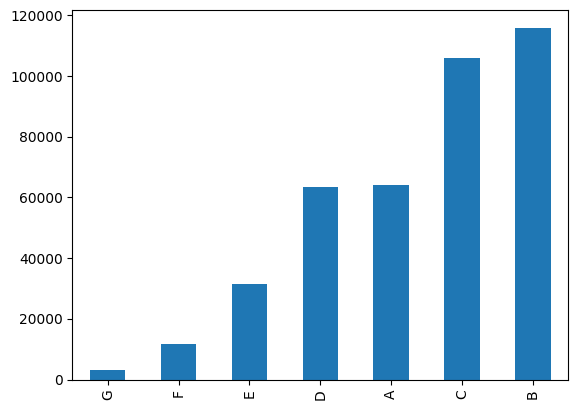

In [249]:
df["grade"].value_counts().sort_values().plot(kind = "bar")

In [250]:
pd.crosstab(index = df["grade"],
            columns= df["loan_status"],normalize= "index", margins = True)

loan_status,Charged Off,Fully Paid
grade,,
A,0.062879,0.937121
B,0.125730,0.874270
C,0.211809,0.788191
D,0.288678,0.711322
E,0.373634,0.626366
F,0.427880,0.572120
G,0.478389,0.521611
All,0.196129,0.803871


<Axes: xlabel='grade'>

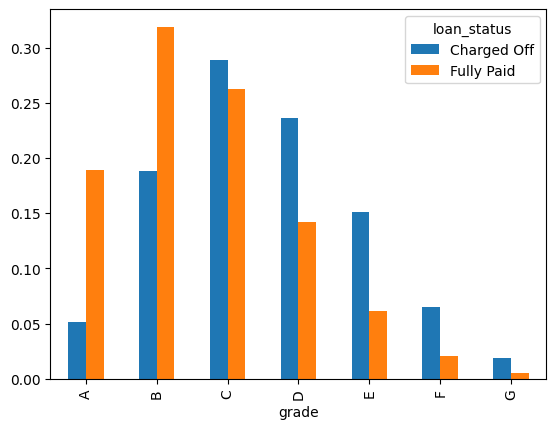

In [251]:
pd.crosstab(index = df["grade"],
            columns= df["loan_status"],normalize= "columns").plot(kind  = "bar")

* LoanTap assigned loan grade
* Loan grades are set based on both the borrower's credit profile and the nature of the contract.

<Axes: xlabel='sub_grade'>

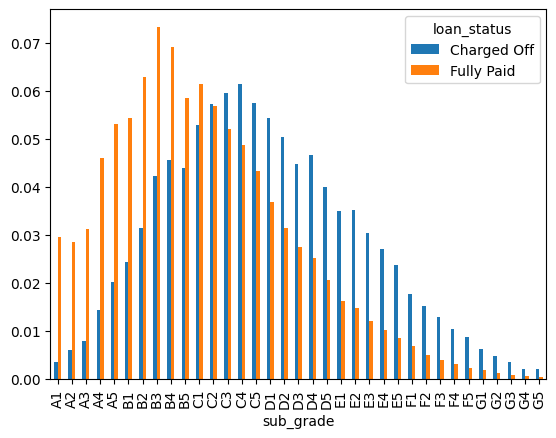

In [252]:
pd.crosstab(index = df["sub_grade"],
            columns= df["loan_status"],normalize= "columns", ).plot(kind = "bar")

[Text(0, 0, 'A1'),
 Text(1, 0, 'A2'),
 Text(2, 0, 'A3'),
 Text(3, 0, 'A4'),
 Text(4, 0, 'A5'),
 Text(5, 0, 'B1'),
 Text(6, 0, 'B2'),
 Text(7, 0, 'B3'),
 Text(8, 0, 'B4'),
 Text(9, 0, 'B5'),
 Text(10, 0, 'C1'),
 Text(11, 0, 'C2'),
 Text(12, 0, 'C3'),
 Text(13, 0, 'C4'),
 Text(14, 0, 'C5'),
 Text(15, 0, 'D1'),
 Text(16, 0, 'D2'),
 Text(17, 0, 'D3'),
 Text(18, 0, 'D4'),
 Text(19, 0, 'D5'),
 Text(20, 0, 'E1'),
 Text(21, 0, 'E2'),
 Text(22, 0, 'E3'),
 Text(23, 0, 'E4'),
 Text(24, 0, 'E5'),
 Text(25, 0, 'F1'),
 Text(26, 0, 'F2'),
 Text(27, 0, 'F3'),
 Text(28, 0, 'F4'),
 Text(29, 0, 'F5'),
 Text(30, 0, 'G1'),
 Text(31, 0, 'G2'),
 Text(32, 0, 'G3'),
 Text(33, 0, 'G4'),
 Text(34, 0, 'G5')]

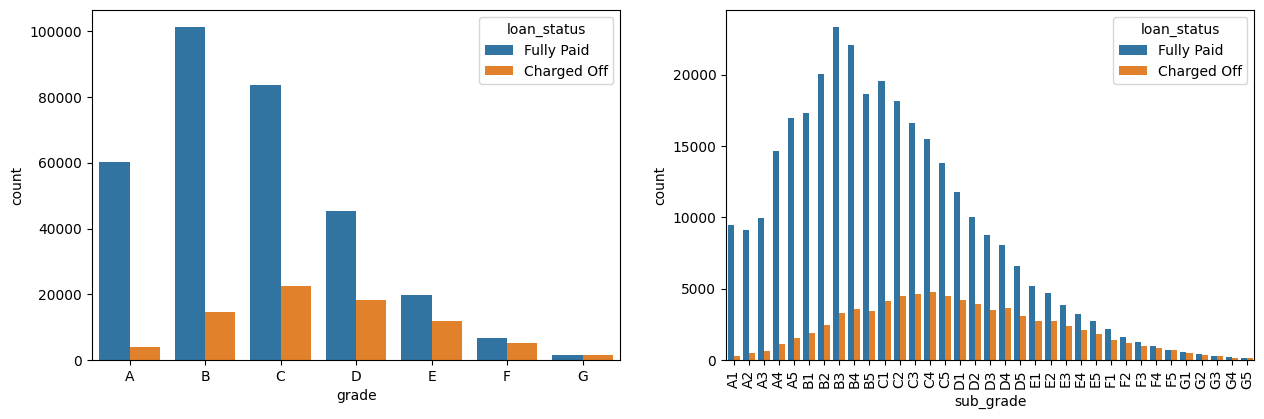

In [253]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=df, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(df.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=df, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [254]:
pd.crosstab(index = df["emp_length"],
            columns= df["loan_status"],normalize= "index", margins = True)*100

loan_status,Charged Off,Fully Paid
emp_length,,
1 year,19.913453,80.086547
10+ years,18.418610,81.581390
2 years,19.326206,80.673794
3 years,19.523133,80.476867
4 years,19.238477,80.761523
5 years,19.218721,80.781279
6 years,18.919438,81.080562
7 years,19.477400,80.522600
8 years,19.976002,80.023998


<Axes: xlabel='emp_length'>

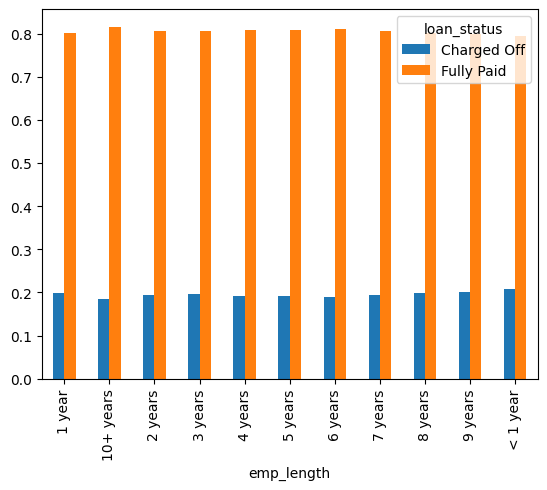

In [255]:
pd.crosstab(index = df["emp_length"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")

* Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

[Text(0, 0, 'vacation'),
 Text(1, 0, 'debt_consolidation'),
 Text(2, 0, 'credit_card'),
 Text(3, 0, 'home_improvement'),
 Text(4, 0, 'small_business'),
 Text(5, 0, 'major_purchase'),
 Text(6, 0, 'other'),
 Text(7, 0, 'medical'),
 Text(8, 0, 'wedding'),
 Text(9, 0, 'car'),
 Text(10, 0, 'moving'),
 Text(11, 0, 'house'),
 Text(12, 0, 'educational'),
 Text(13, 0, 'renewable_energy')]

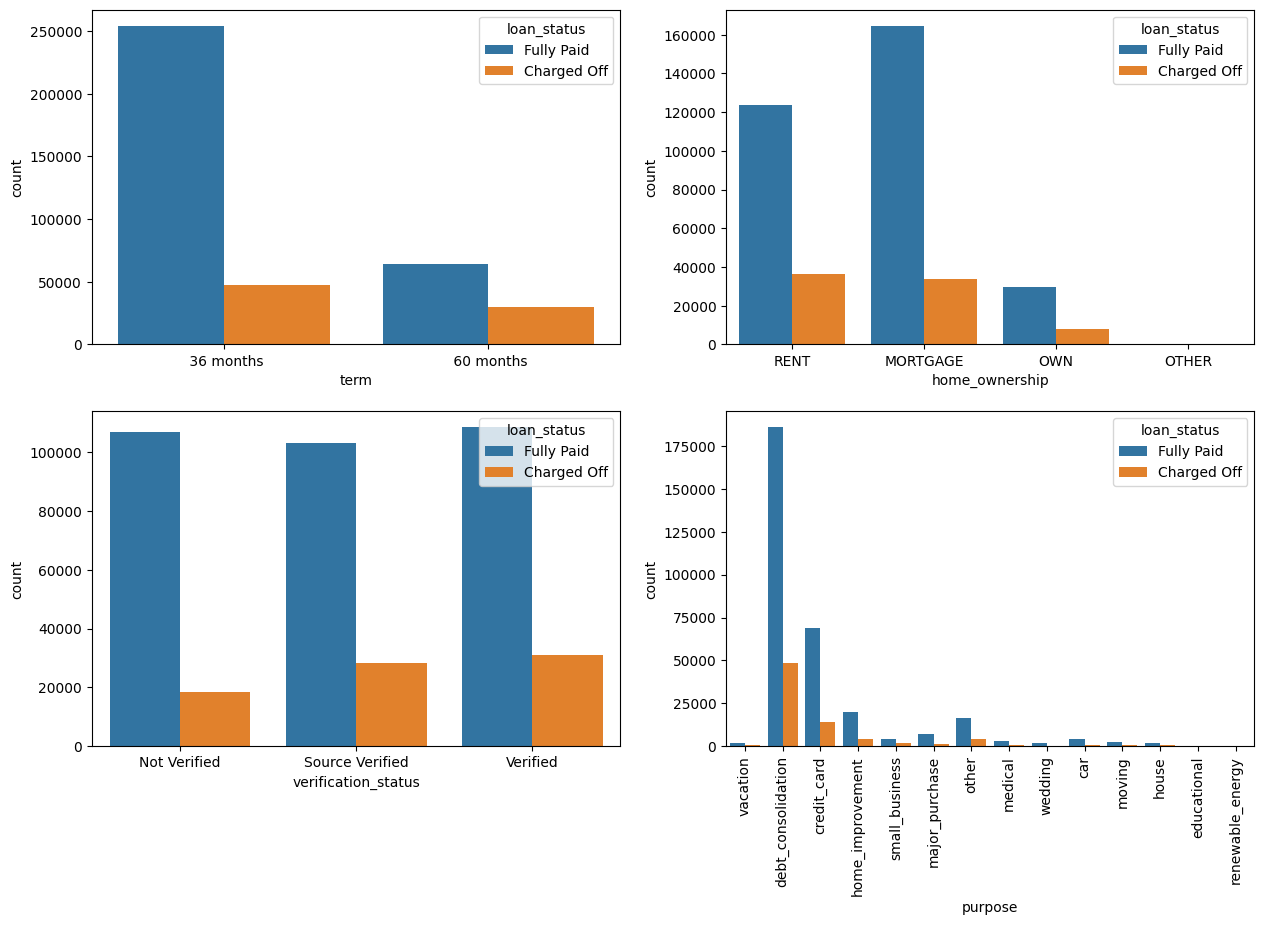

In [256]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
sns.countplot(x='term',data=df,hue='loan_status')

plt.subplot(4,2,2)
sns.countplot(x='home_ownership',data=df,hue='loan_status')

plt.subplot(4,2,3)
sns.countplot(x='verification_status',data=df,hue='loan_status')

plt.subplot(4,2,4)
g=sns.countplot(x='purpose',data=df,hue='loan_status')
g.set_xticklabels(g.get_xticklabels(),rotation=90)

* mostly 36 month duration periods loans status are fully paid
* the purpose of who buy loans for "debt_consolidation" is mostly paid and mostly charged off

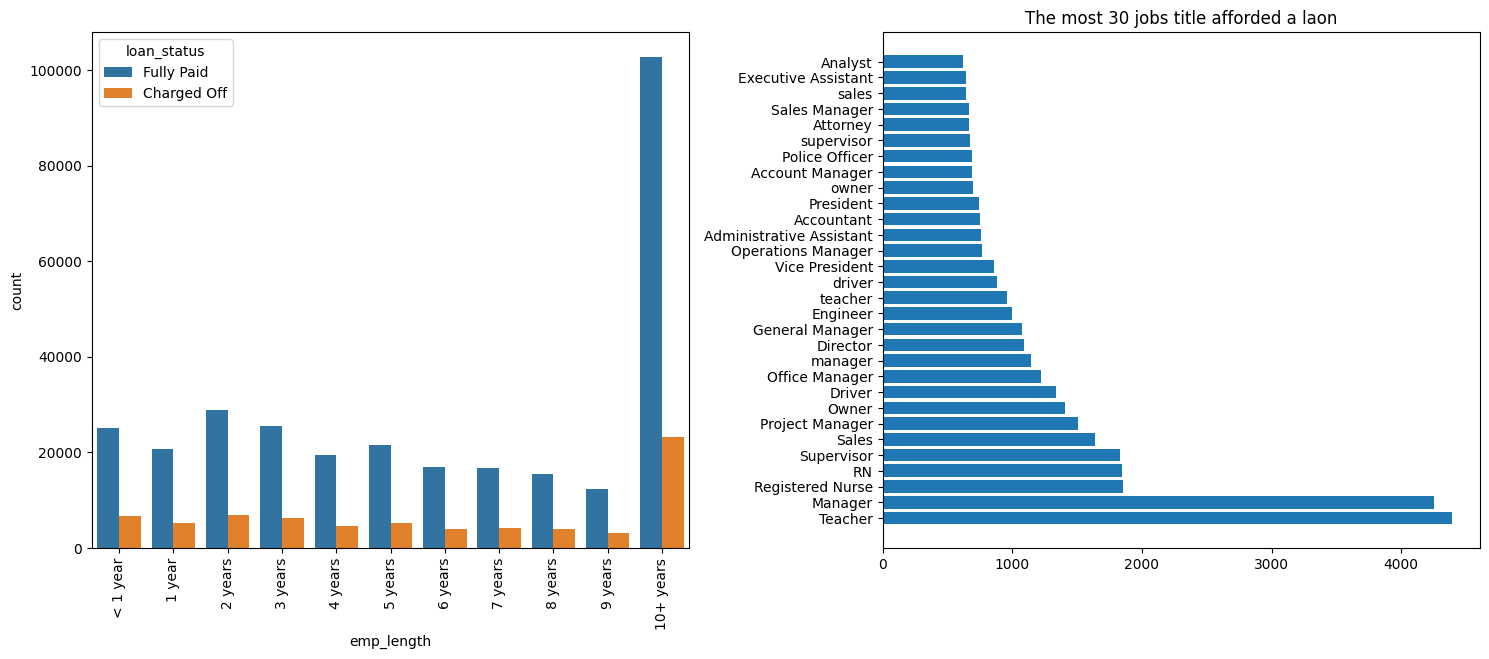

In [257]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g=sns.countplot(x='emp_length',data=df,hue='loan_status',order=order)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.subplot(2,2,2)
plt.barh(df.emp_title.value_counts()[:30].index,df.emp_title.value_counts()[:30])
plt.title("The most 30 jobs title afforded a laon")
plt.tight_layout()

* duration of loans paid max time is 10+ year
* Manager and Teacher are the most afforded loan on titles

In [258]:
df['issue_d']=pd.to_datetime(df['issue_d'])
df['earliest_cr_line']=pd.to_datetime(df['earliest_cr_line'])

In [259]:
df["home_ownership"].value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: home_ownership, dtype: int64

In [260]:
df["home_ownership"] = df["home_ownership"].replace({"NONE":"OTHER", "ANY":"OTHER"})

In [261]:
pd.crosstab(index = df["home_ownership"],
            columns= df["loan_status"],normalize= "index", margins = True)*100

loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,16.956057,83.043943
OTHER,15.753425,84.246575
OWN,20.680337,79.319663
RENT,22.662244,77.337756
All,19.612908,80.387092


<Axes: xlabel='home_ownership'>

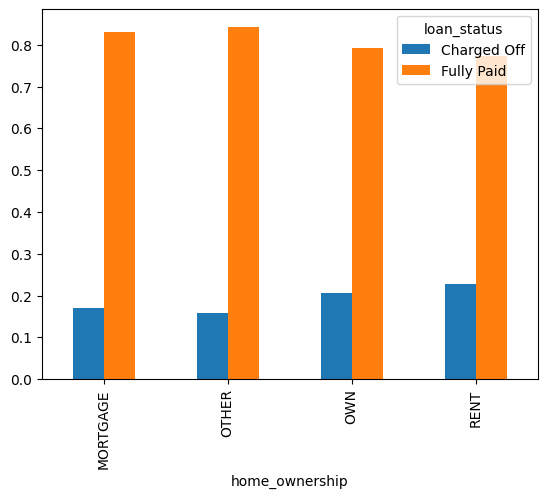

In [262]:
pd.crosstab(index = df["home_ownership"],
            columns= df["loan_status"],normalize= "index").plot(kind= "bar")

In [263]:
#so im just flagging anything more than 0 as 1

def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1

def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number


def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

In [264]:
df['pub_rec']=df.pub_rec.apply(pub_rec)
df['mort_acc']=df.mort_acc.apply(mort_acc)
df['pub_rec_bankruptcies']=df.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

<Axes: xlabel='pub_rec_bankruptcies', ylabel='count'>

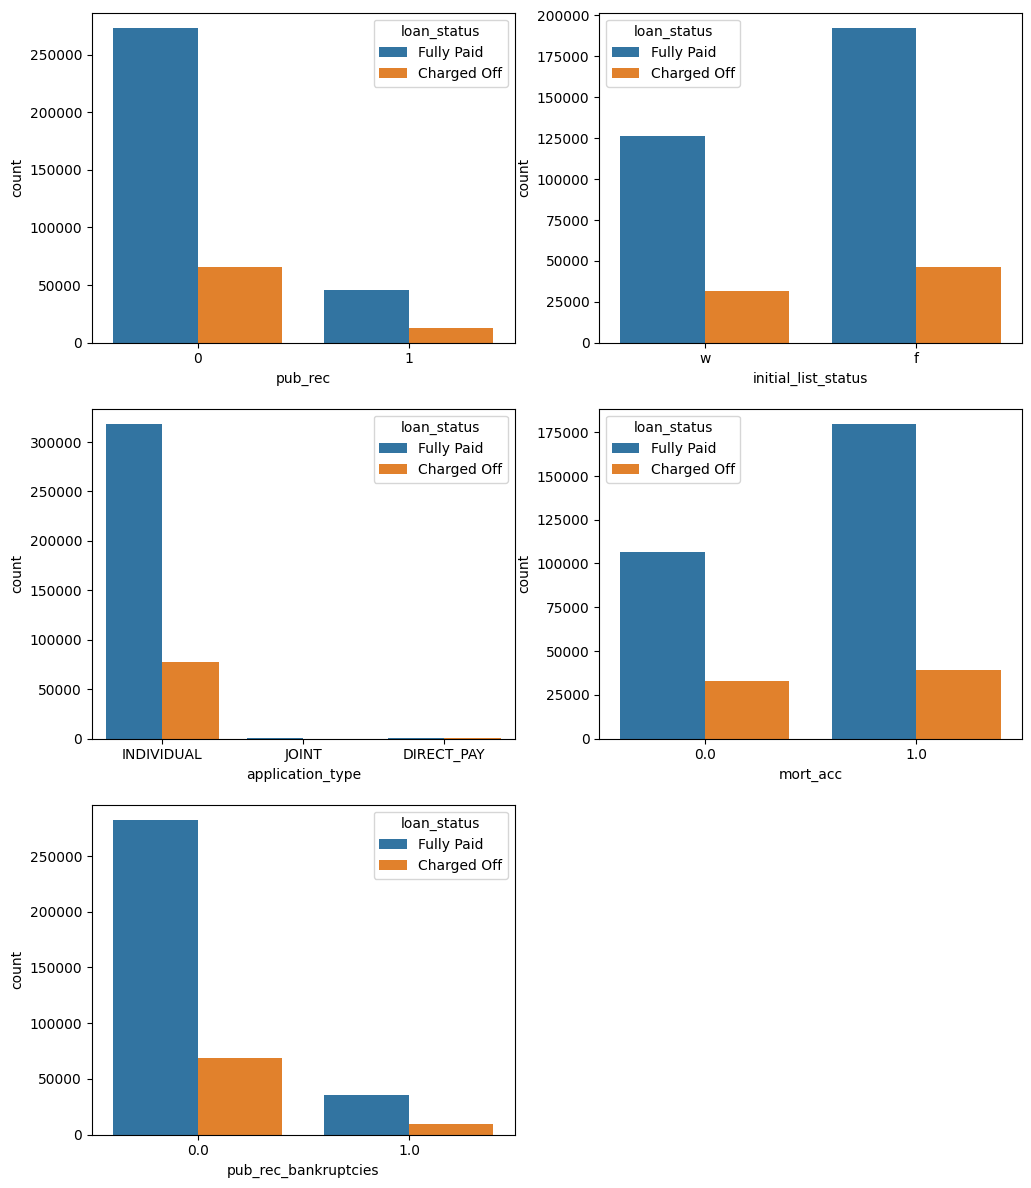

In [265]:
plt.figure(figsize=(12,30))

plt.subplot(6,2,1)
sns.countplot(x='pub_rec',data=df,hue='loan_status')

plt.subplot(6,2,2)
sns.countplot(x='initial_list_status',data=df,hue='loan_status')

plt.subplot(6,2,3)
sns.countplot(x='application_type',data=df,hue='loan_status')

plt.subplot(6,2,4)
sns.countplot(x='mort_acc',data=df,hue='loan_status')

plt.subplot(6,2,5)
sns.countplot(x='pub_rec_bankruptcies',data=df,hue='loan_status')

In [266]:
# Mapping of target variable
df['loan_status']=df.loan_status.map({'Fully Paid':0, 'Charged Off':1})

In [267]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [268]:
pd.crosstab(index = df["verification_status"],
            columns= df["loan_status"],normalize= "index", margins = True)*100

loan_status,0,1
verification_status,,
Not Verified,85.364001,14.635999
Source Verified,78.525707,21.474293
Verified,77.678898,22.321102
All,80.387092,19.612908


<Axes: xlabel='verification_status'>

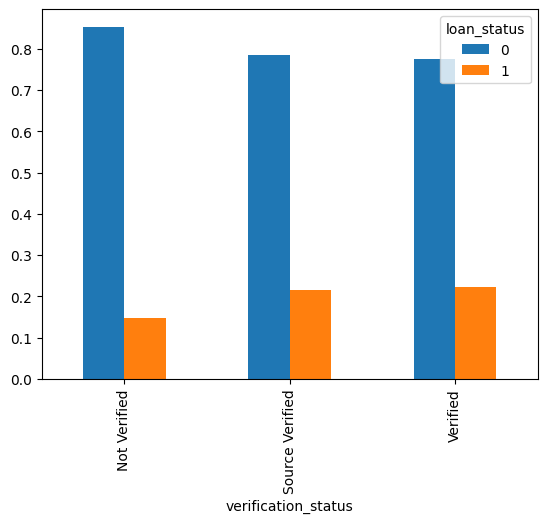

In [269]:
pd.crosstab(index = df["verification_status"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")

purpose :
A category provided by the borrower for the loan request.

In [270]:
pd.crosstab(index = df["purpose"],
            columns= df["loan_status"],normalize= "index", margins = True)*100

loan_status,0,1
purpose,,
car,86.523313,13.476687
credit_card,83.288163,16.711837
debt_consolidation,79.258615,20.741385
educational,83.657588,16.342412
home_improvement,82.992093,17.007907
house,80.281690,19.718310
major_purchase,83.526735,16.473265
medical,78.288847,21.711153
moving,76.524177,23.475823


<Axes: xlabel='purpose'>

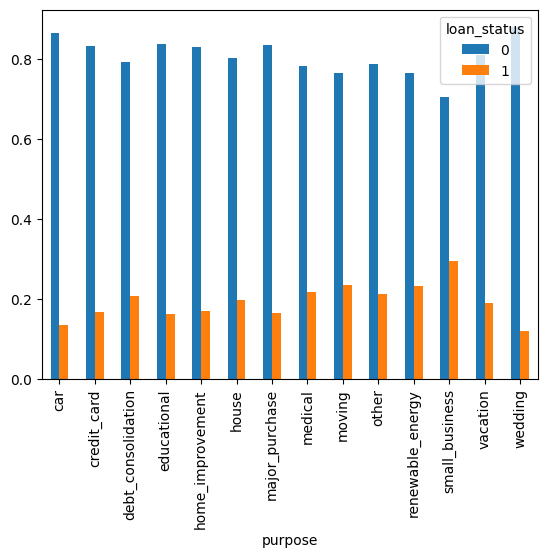

In [271]:
pd.crosstab(index = df["purpose"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")

<Axes: >

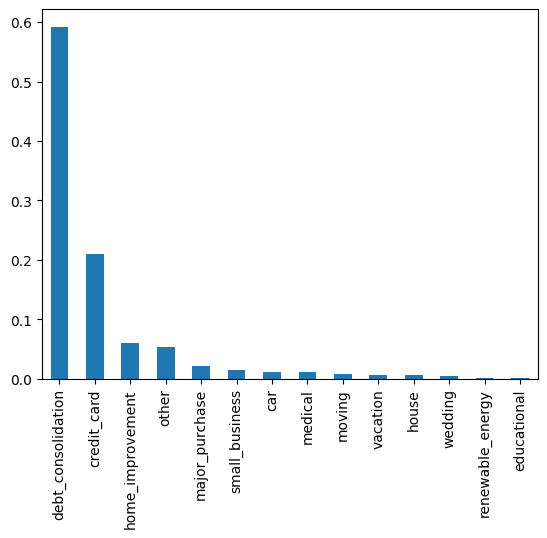

In [272]:
(df["purpose"].value_counts(dropna=False,normalize=True)).plot(kind = "bar")

loan_status : Current status of the loan - Target Variable

<Axes: >

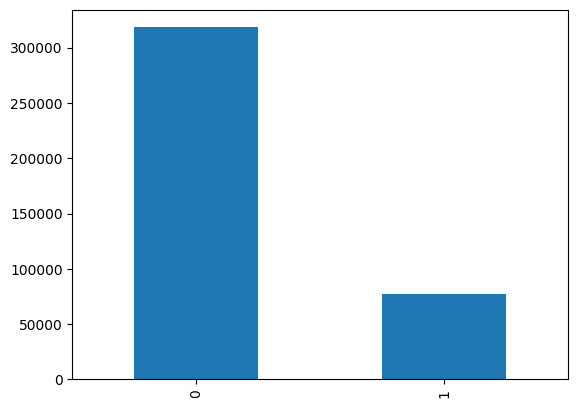

In [273]:
df["loan_status"].value_counts(dropna=False).plot(kind = "bar")

dti :
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LoanTap loan, divided by the borrower’s self-reported monthly income.

In [274]:
df["dti"].describe()

count    396030.000000
mean         17.379514
std          18.019092
min           0.000000
25%          11.280000
50%          16.910000
75%          22.980000
max        9999.000000
Name: dti, dtype: float64

<Axes: >

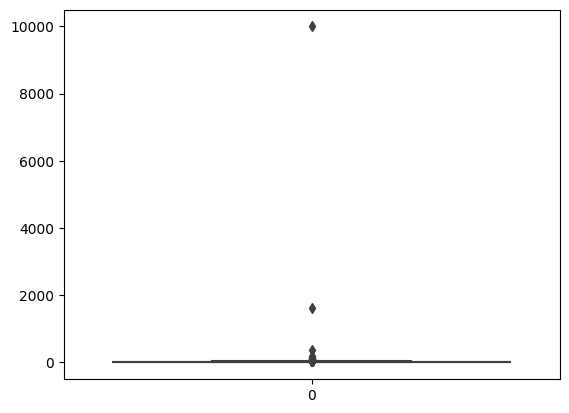

In [275]:
sns.boxplot((df["dti"]))

<Axes: xlabel='loan_status', ylabel='dti'>

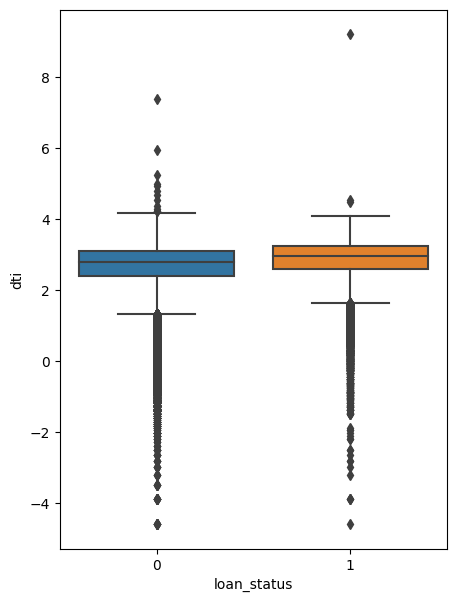

In [276]:
# looks like there are lots of outliers in dti column .
plt.figure(figsize=(5,7))
sns.boxplot(y=np.log(df[df["dti"]>0]["dti"]),
            x=df["loan_status"])

earliest_cr_line :
The month the borrower's earliest reported credit line was opened

In [277]:
# pd.to_datetime(df["earliest_cr_line"])
df["Loan_Tenure"] = ((pd.to_datetime(df["issue_d"]) -pd.to_datetime(df["earliest_cr_line"]))/np.timedelta64(1, 'M'))


<Axes: ylabel='Count'>

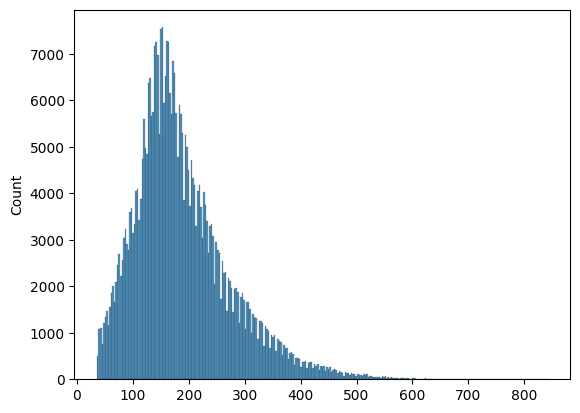

In [278]:
sns.histplot(((pd.to_datetime(df["issue_d"]) -pd.to_datetime(df["earliest_cr_line"]))/np.timedelta64(1, 'M')))

<Axes: xlabel='loan_status'>

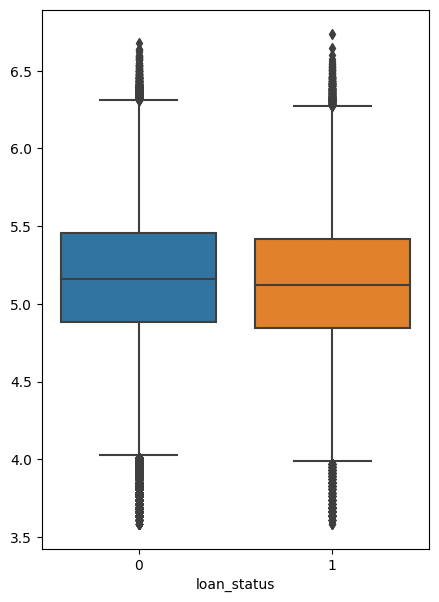

In [279]:
plt.figure(figsize=(5,7))
sns.boxplot(y=np.log(((pd.to_datetime(df["issue_d"]) -pd.to_datetime(df["earliest_cr_line"]))/np.timedelta64(1, 'M'))),
            x=df["loan_status"])

open_acc :
The number of open credit lines in the borrower's credit file.

In [280]:
df.groupby("loan_status")["open_acc"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,318357.0,11.240067,5.097647,0.0,8.0,10.0,14.0,90.0
1,77673.0,11.602513,5.288507,0.0,8.0,11.0,14.0,76.0


In [281]:
df["open_acc"].nunique()

61

<Axes: xlabel='open_acc', ylabel='Count'>

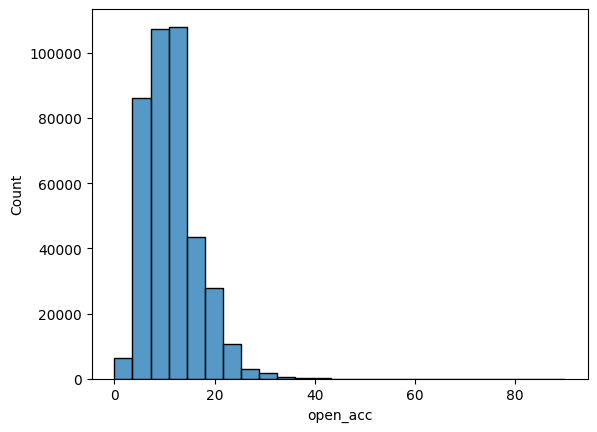

In [282]:
sns.histplot(df["open_acc"],bins = 25)

<Axes: xlabel='loan_status', ylabel='open_acc'>

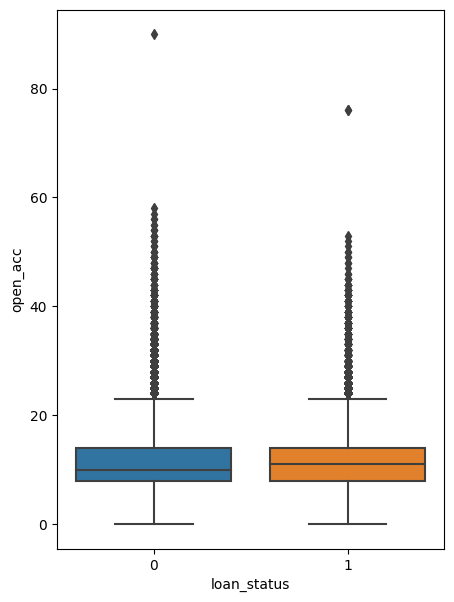

In [283]:
plt.figure(figsize=(5,7))
sns.boxplot(y= df["open_acc"],
            x=df["loan_status"])

pub_rec :
* Number of derogatory public records

* “Derogatory” is seen as negative to lenders, and can include late payments, collection accounts, bankruptcy, charge-offs and other negative marks on your credit report. This can impact your ability to qualify for new credit.

In [284]:
df.groupby("loan_status")["pub_rec"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,318357.0,0.142683,0.349749,0.0,0.0,0.0,0.0,1.0
1,77673.0,0.158794,0.365486,0.0,0.0,0.0,0.0,1.0


<Axes: xlabel='loan_status', ylabel='pub_rec'>

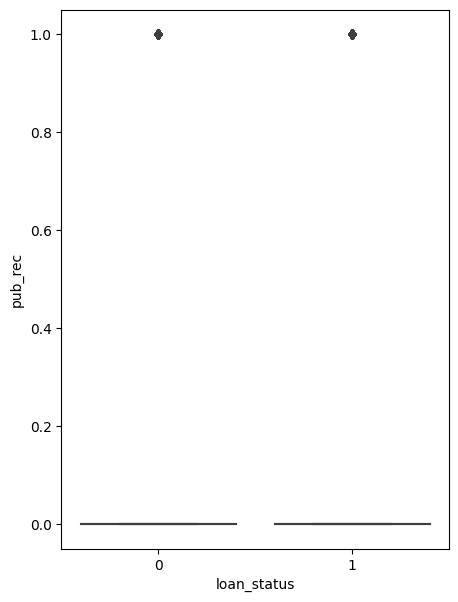

In [285]:
plt.figure(figsize=(5,7))
sns.boxplot(y= df["pub_rec"],
            x=df["loan_status"])

0    338272
1     57758
Name: pub_rec, dtype: int64


<Axes: xlabel='pub_rec'>

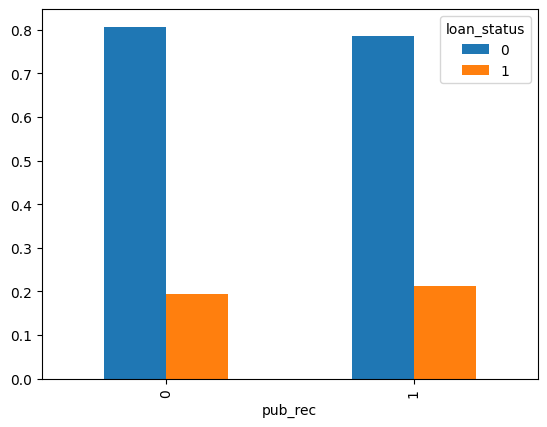

In [286]:
print(df["pub_rec"].value_counts(dropna=False))
pd.crosstab(index = df["pub_rec"],
            columns= df["loan_status"],normalize= "index", margins = True)*100
pd.crosstab(index = df["pub_rec"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")

revol_bal :

*Total credit revolving balance

* With revolving credit, a consumer has a line of credit he can keep using and repaying over and over. The balance that carries over from one month to the next is the revolving balance on that loan.

In [287]:
df.groupby("loan_status")["revol_bal"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,318357.0,15955.327918,21132.193457,0.0,5992.0,11158.0,19657.0,1743266.0
1,77673.0,15390.454701,18203.387930,0.0,6150.0,11277.0,19485.0,1030826.0


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='revol_bal', ylabel='Count'>

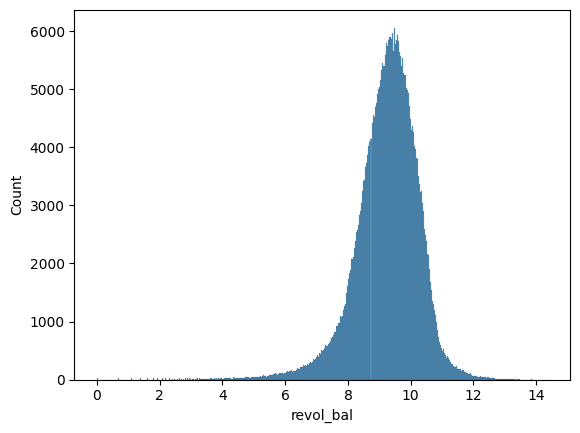

In [288]:
sns.histplot(np.log(df["revol_bal"]))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='loan_status', ylabel='revol_bal'>

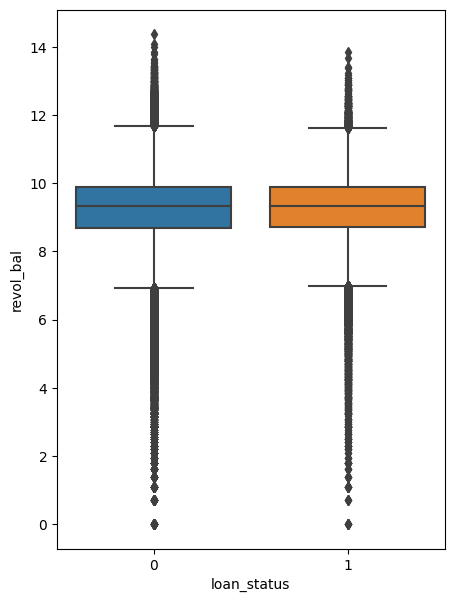

In [289]:
plt.figure(figsize=(5,7))
sns.boxplot(y= np.log(df["revol_bal"]),
            x=df["loan_status"])

* revol_util :

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
Your credit utilization rate, sometimes called your credit utilization ratio, is the amount of revolving credit you're currently using divided by the total amount of revolving credit you have available. In other words, it's how much you currently owe divided by your credit limit. It is generally expressed as a percent.

In [290]:
df.groupby("loan_status")["revol_util"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,318144.0,52.796918,24.578304,0.0,34.6,53.7,72.0,892.3
1,77610.0,57.869824,23.492176,0.0,41.2,59.3,76.2,148.0


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='loan_status', ylabel='revol_util'>

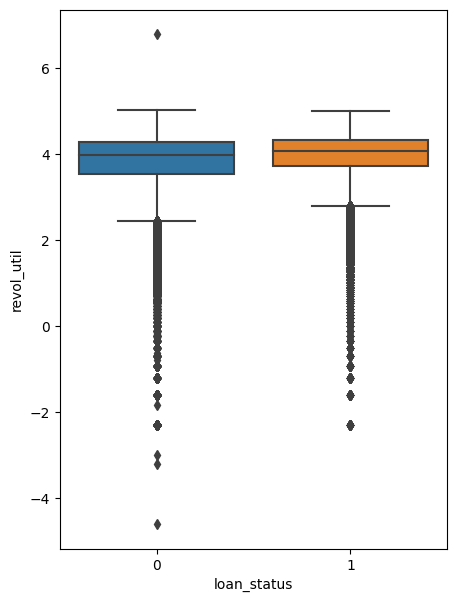

In [291]:
plt.figure(figsize=(5,7))
sns.boxplot(y= np.log(df["revol_util"]),
            x=df["loan_status"])

total_acc :

The total number of credit lines currently in the borrower's credit file

In [292]:
df.groupby("loan_status")["total_acc"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,318357.0,25.519800,11.878117,2.0,17.0,24.0,32.0,150.0
1,77673.0,24.984152,11.913692,2.0,16.0,23.0,32.0,151.0


<Axes: xlabel='loan_status', ylabel='total_acc'>

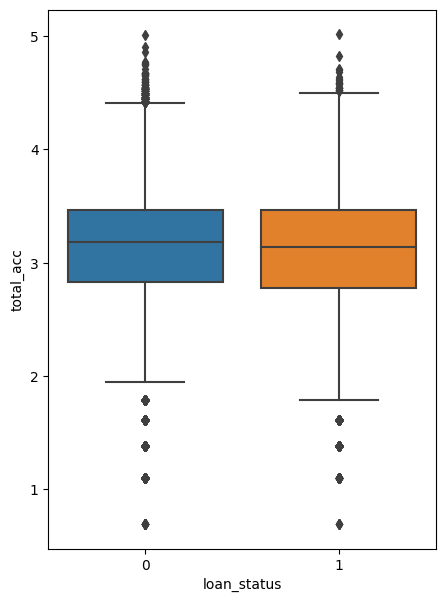

In [293]:
plt.figure(figsize=(5,7))
sns.boxplot(y= np.log(df["total_acc"]),
            x=df["loan_status"])

initial_list_status :

The initial listing status of the loan. Possible values are – W, F

f    238066
w    157964
Name: initial_list_status, dtype: int64


<Axes: xlabel='initial_list_status'>

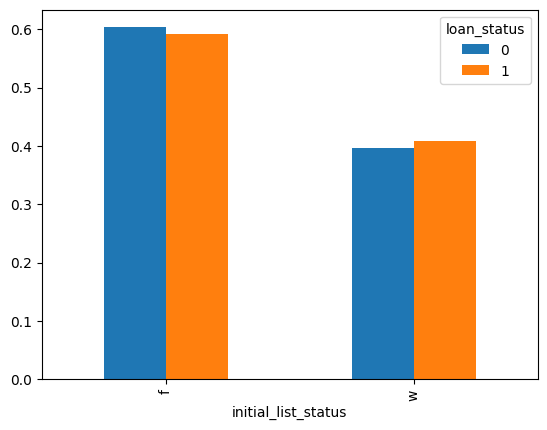

In [294]:
print(df["initial_list_status"].value_counts(dropna=False))

pd.crosstab(index = df["initial_list_status"],
            columns= df["loan_status"],normalize= "columns").plot(kind = "bar")

application_type :

Indicates whether the loan is an individual application or a joint application with two co-borrowers

INDIVIDUAL    395319
JOINT            425
DIRECT_PAY       286
Name: application_type, dtype: int64


<Axes: xlabel='application_type'>

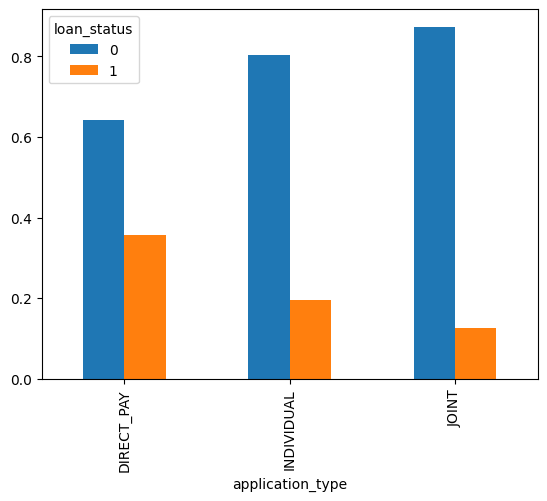

In [295]:
print(df["application_type"].value_counts(dropna=False))

pd.crosstab(index = df["application_type"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")

mort_acc :

Number of mortgage accounts

In [296]:
df.groupby("loan_status")["mort_acc"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,286112.0,0.627349,0.483511,0.0,0.0,1.0,1.0,1.0
1,72123.0,0.540271,0.498379,0.0,0.0,1.0,1.0,1.0


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


<Axes: xlabel='loan_status', ylabel='mort_acc'>

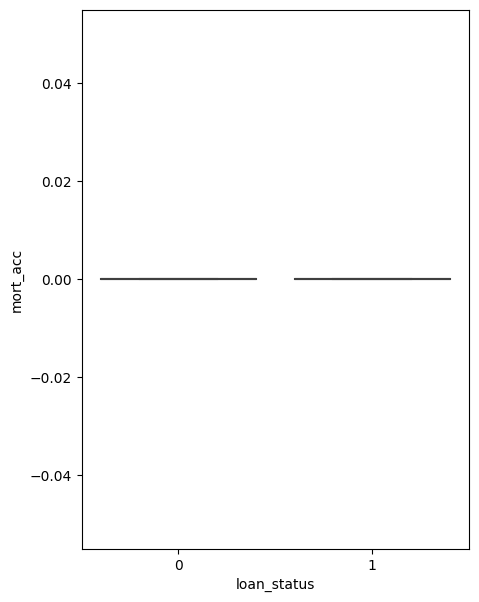

In [297]:
plt.figure(figsize=(5,7))
sns.boxplot(y= np.log(df["mort_acc"]),
            x=df["loan_status"])

<Axes: xlabel='mort_acc'>

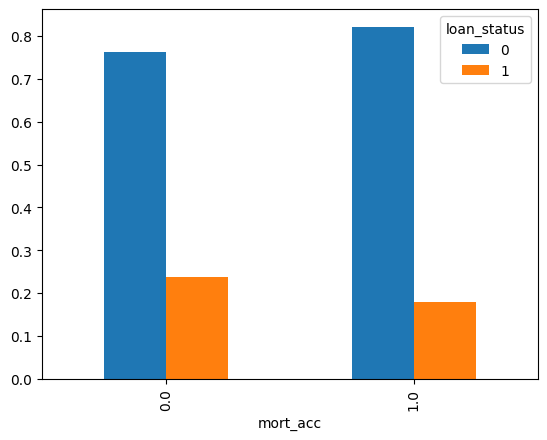

In [298]:
pd.crosstab(index = df["mort_acc"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")

pub_rec_bankruptcies :

Number of public record bankruptcies

0.0    350380
1.0     45115
NaN       535
Name: pub_rec_bankruptcies, dtype: int64
loan_status                   0          1
pub_rec_bankruptcies                      
0.0                   80.500885  19.499115
1.0                   79.463593  20.536407
All                   80.382559  19.617441


<Axes: xlabel='pub_rec_bankruptcies'>

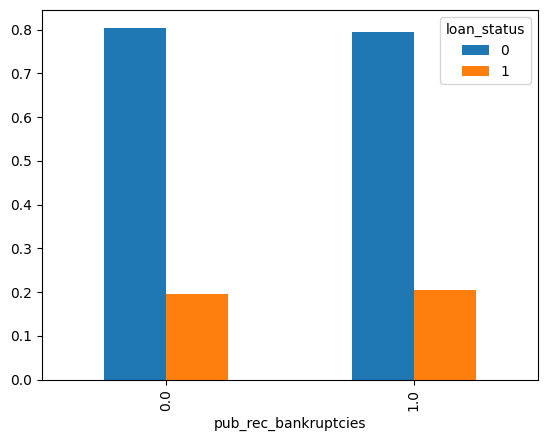

In [299]:
print(df["pub_rec_bankruptcies"].value_counts(dropna=False))
print(pd.crosstab(index = df["pub_rec_bankruptcies"],
            columns= df["loan_status"],normalize= "index", margins = True)*100)
pd.crosstab(index = df["pub_rec_bankruptcies"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")

Address:

Address of the individual

In [300]:
df["address"][10]
df["pincode"] = df["address"].str.split().apply(lambda x:x[-1])

* from address pincode separeted

annual_inc :

The self-reported annual income provided by the borrower during registration.

<ipython-input-301-c31ff4201efc>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["annual_inc"])


<Axes: xlabel='annual_inc', ylabel='Density'>

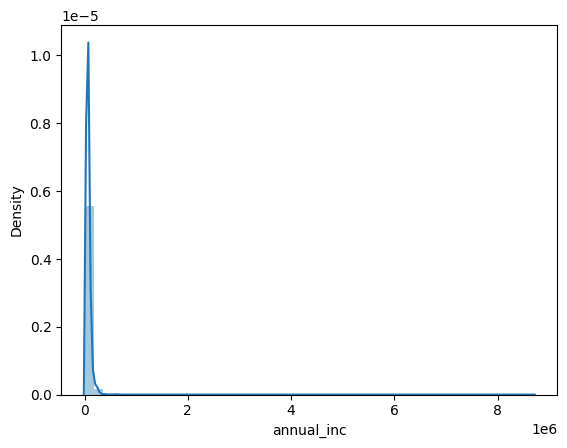

In [301]:
sns.distplot(df["annual_inc"])

In [302]:
df["annual_inc"].describe()

count    3.960300e+05
mean     7.420318e+04
std      6.163762e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.400000e+04
75%      9.000000e+04
max      8.706582e+06
Name: annual_inc, dtype: float64

<ipython-input-303-b7f7febce012>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(df[df["annual_inc"]>0]["annual_inc"]))


<Axes: xlabel='annual_inc', ylabel='Density'>

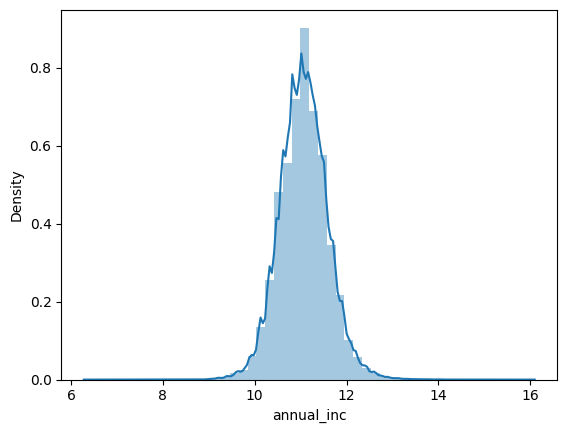

In [303]:
sns.distplot(np.log(df[df["annual_inc"]>0]["annual_inc"]))

<Axes: xlabel='loan_status', ylabel='annual_inc'>

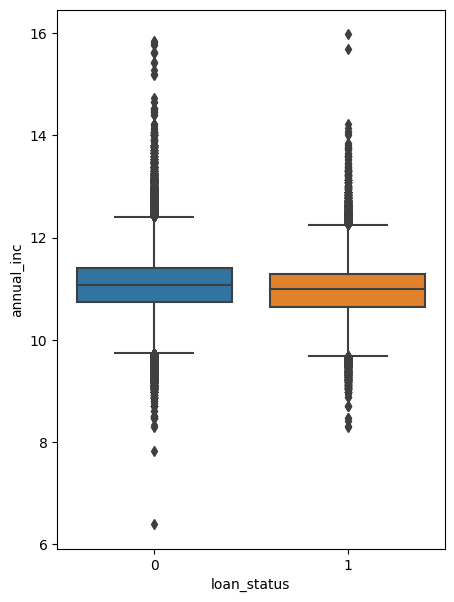

In [304]:
plt.figure(figsize=(5,7))
sns.boxplot(y=np.log(df[df["annual_inc"]>0]["annual_inc"]),
            x=df["loan_status"])

* from above boxplot, there seems to be no difference between annual income,
* for loan status categories

# dropping unimportant columns

In [305]:
df.drop(["title","issue_d","earliest_cr_line","initial_list_status"],axis = 1, inplace=True)

In [306]:
df.drop(["Loan_Tenure"],axis=1,inplace=True)

# Missing value treatment

In [307]:
from sklearn.impute import SimpleImputer
Imputer = SimpleImputer(strategy="most_frequent")
df["mort_acc"] = Imputer.fit_transform(df["mort_acc"].values.reshape(-1,1))

In [308]:
# Dropping rows with null values
df.dropna(inplace=True)

Pre-proccessing :

Feature Engineering

In [309]:
pip install category_encoders

In [310]:
from category_encoders import TargetEncoder

In [311]:
TE = TargetEncoder()

In [312]:
df["loan_status"].replace({"Fully Paid":0,
                          "Charged Off" : 1},inplace=True)

In [313]:
target_enc = ["sub_grade","grade",'term', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'application_type']

In [314]:
for col in target_enc:
    from category_encoders import TargetEncoder
    TEncoder = TargetEncoder()

    df[col] = TEncoder.fit_transform(df[col],df["loan_status"])

Outlier treatment :

In [315]:
def outlier_remover(a,df):

    q1 = a.quantile(.25)
    q3 = a.quantile(.75)
    iqr = q3 - q1

    maxx = q3 + 1.5 * iqr
    minn = q1 - 1.5 * iqr

    return df.loc[(a>=minn) & (a<=maxx)]

In [316]:
floats = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'open_acc','revol_bal', 'revol_util', 'total_acc']

In [317]:
for i in floats:
    df = outlier_remover(df[i],df)

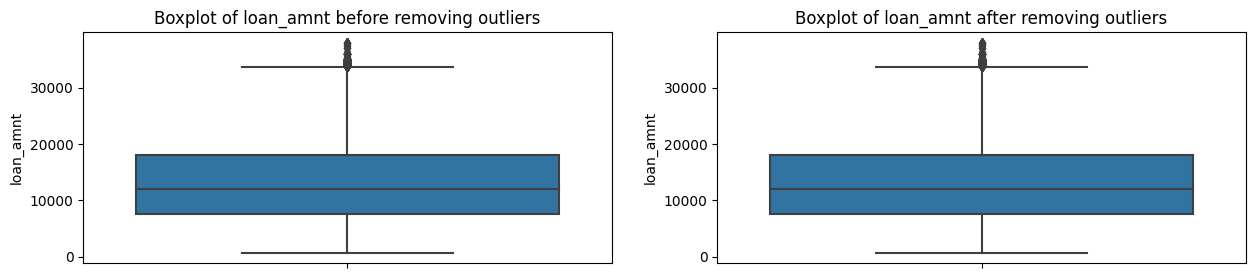

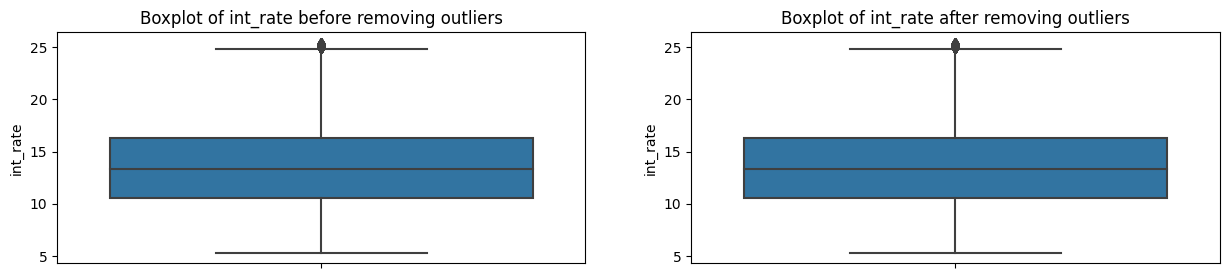

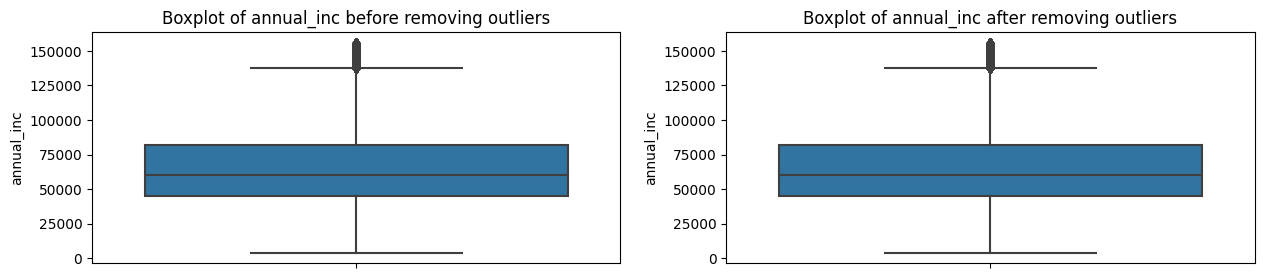

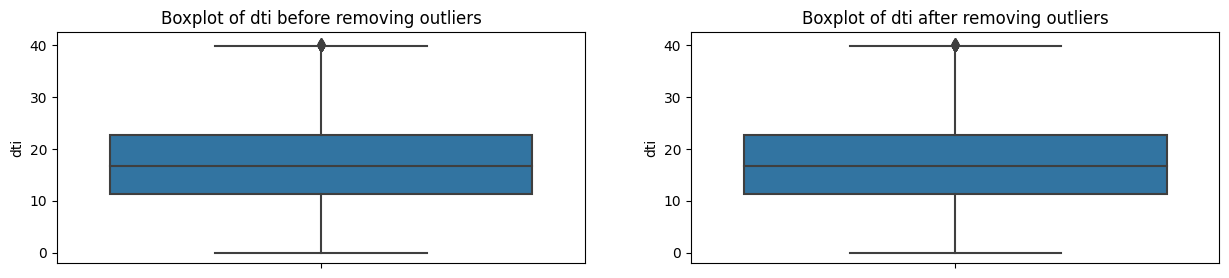

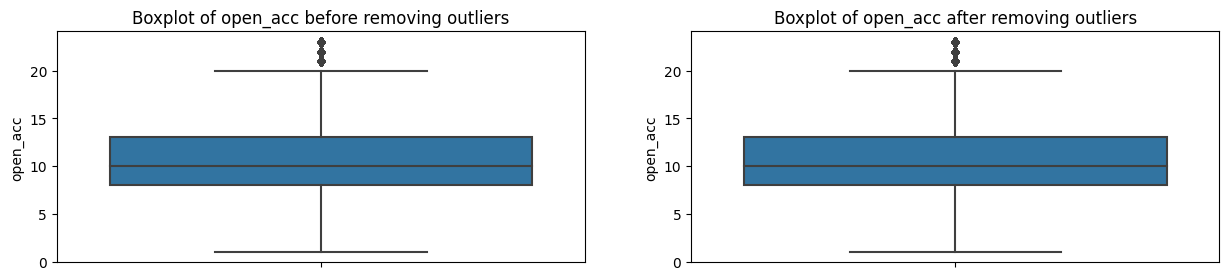

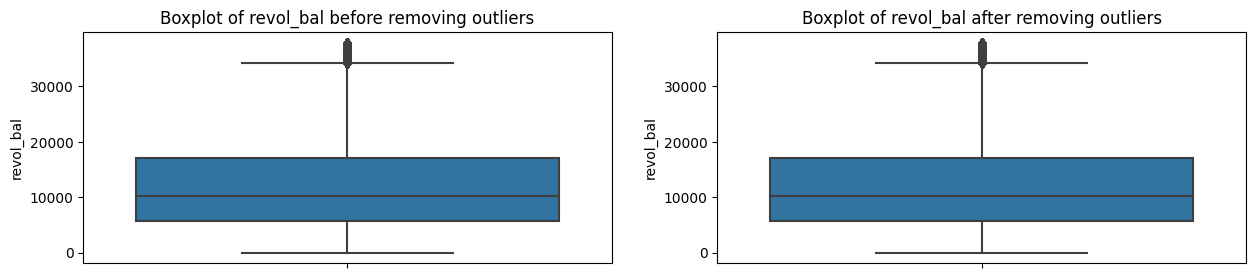

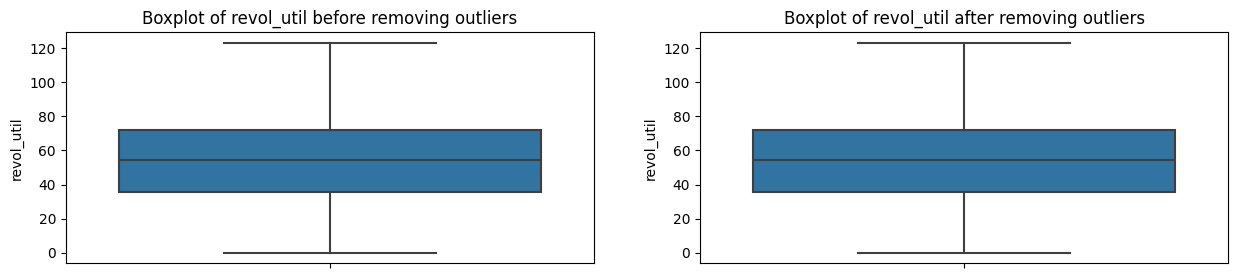

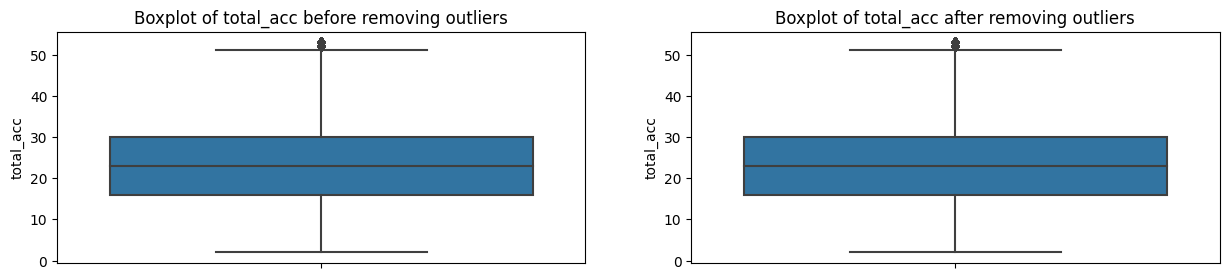

In [318]:
for i in floats:
    plt.figure(figsize=(15, 3))
    plt.subplot(121)
    sns.boxplot(y=df[i])
    plt.title(f"Boxplot of {i} before removing outliers")
    plt.subplot(122)
    sns.boxplot(y=df[i])
    plt.title(f"Boxplot of {i} after removing outliers")

    plt.show()

Missing value check :

In [319]:
def missing_df(data):
    total_missing_df = data.isna().sum().sort_values(ascending = False)
    percentage_missing_df = ((data.isna().sum()/len(data)*100)).sort_values(ascending = False)
    missingDF = pd.concat([total_missing_df, percentage_missing_df],axis = 1, keys=['Total', 'Percent'])
    return missingDF


missing_data = missing_df(df)
missing_data[missing_data["Total"]>0]

,Total,Percent


In [320]:
#dropping unimportant columns
df.drop(["mort_acc","pub_rec_bankruptcies","pub_rec"],axis = 1 , inplace=True)

In [321]:
#dropping unimportant columns
df.drop(["address","pincode",],axis = 1 , inplace=True)

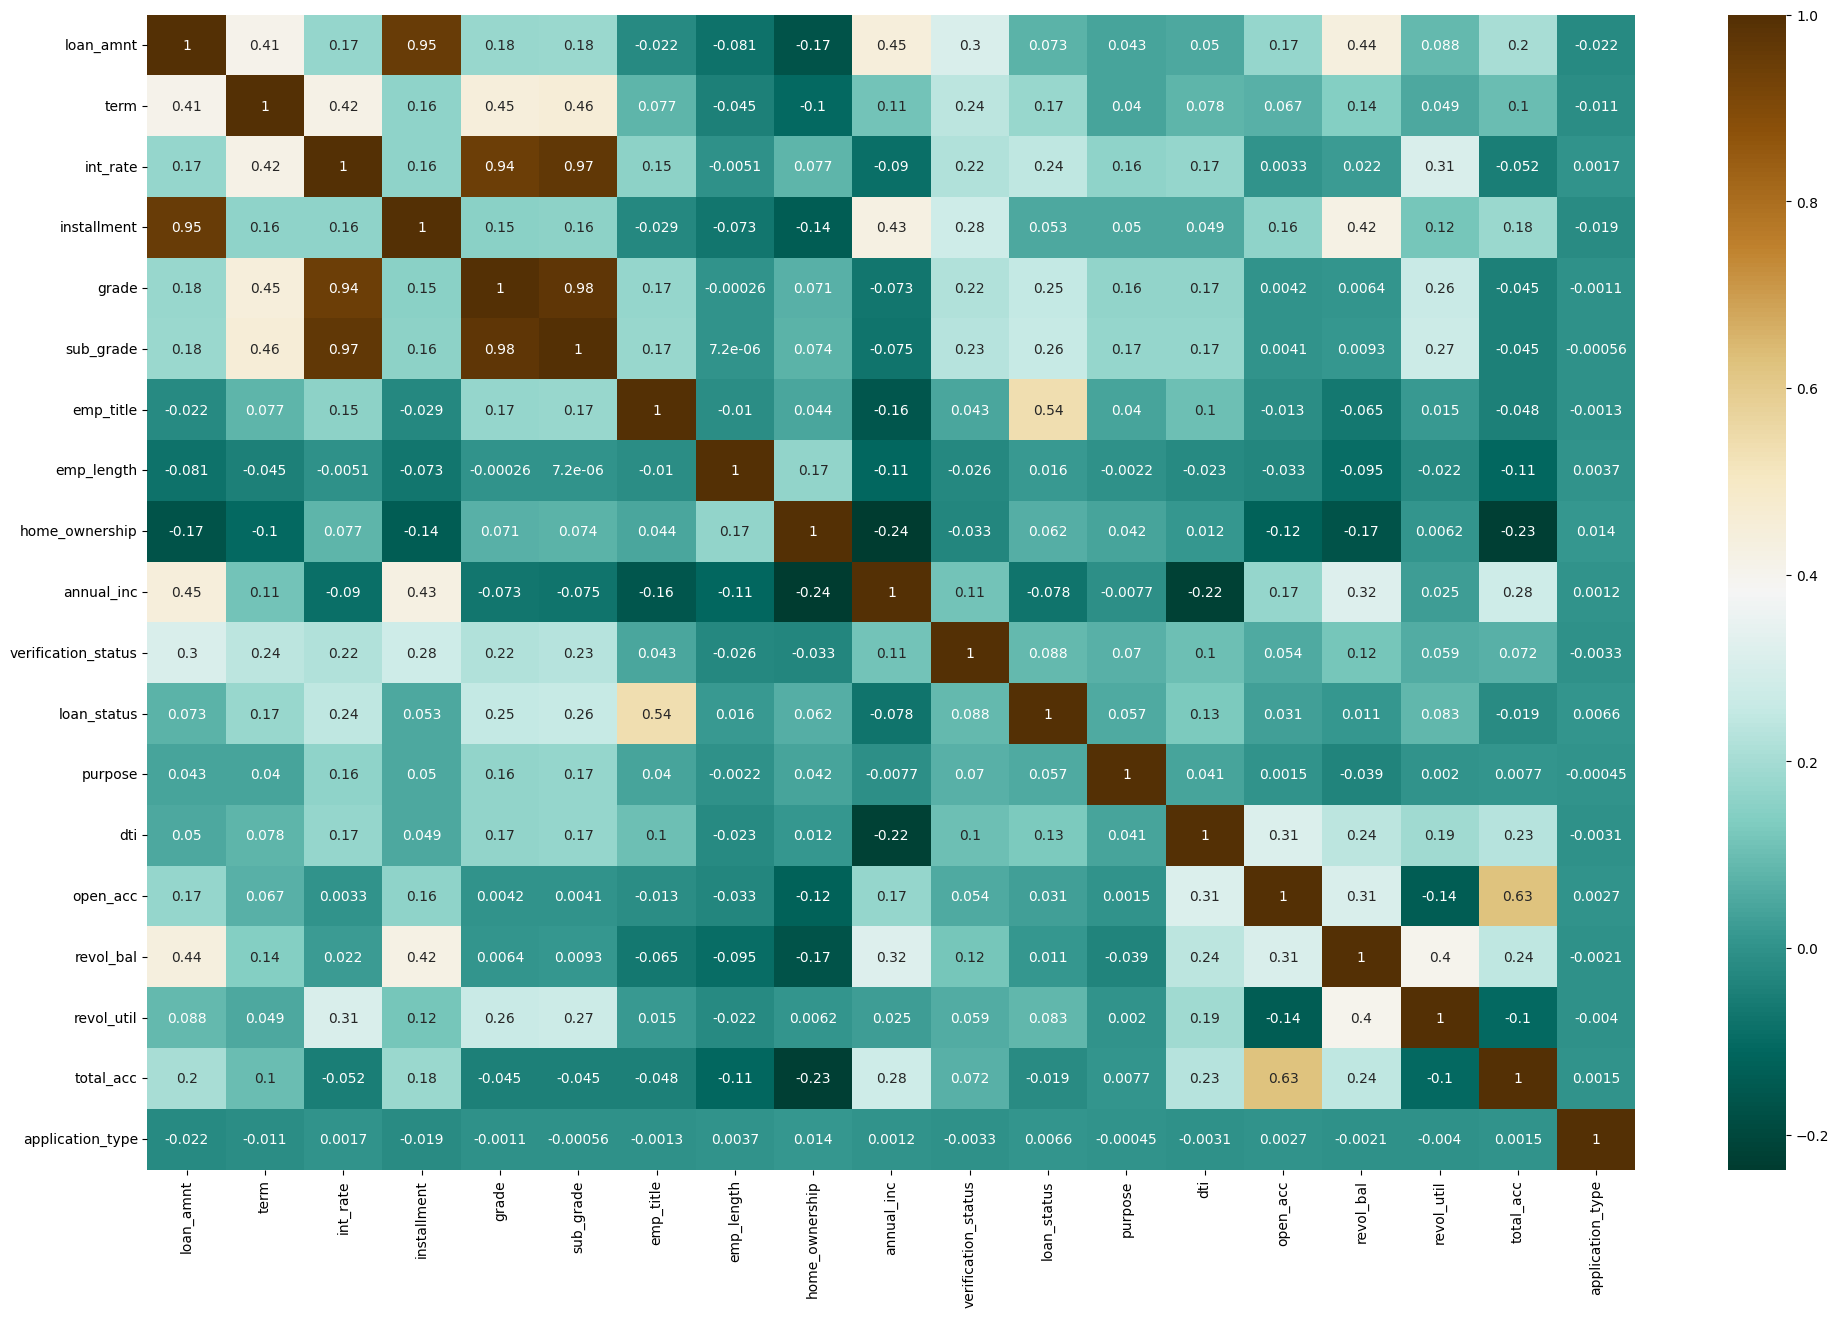

In [322]:
plt.figure(figsize=(24,15))
sns.heatmap(df.corr(),annot=True,cmap='BrBG_r')

plt.show()

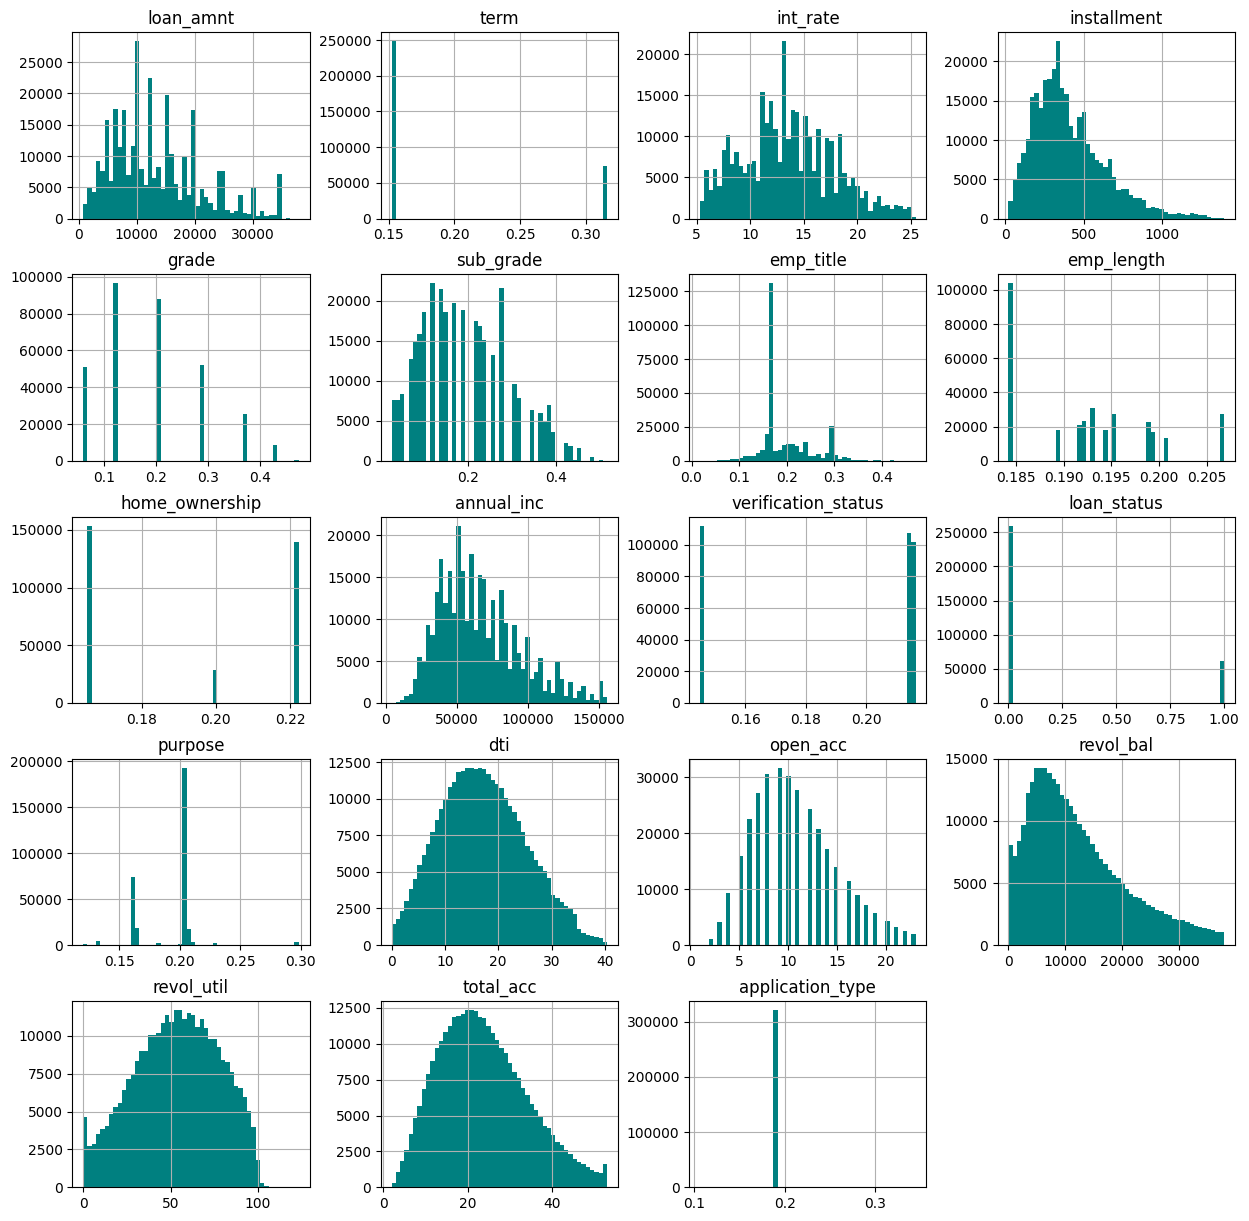

In [ ]:
df.hist(color='teal',figsize=(15,15),bins=50)
plt.show()

# Train-test split :

In [323]:
X = df.drop(["loan_status"],axis = 1)
y = df["loan_status"]

In [324]:
X_train , X_test , y_train , y_test = train_test_split(X,y,random_state=3,test_size=0.2)

In [325]:
print(X_train.shape)
print(X_test.shape)

(257350, 18)
(64338, 18)


In [326]:
model = LogisticRegression()

In [327]:
model.fit(X_train,y_train)

LogisticRegression()

In [328]:
model.score(X_test,y_test)

0.8076098106873076

In [330]:
from sklearn.metrics import f1_score,recall_score,precision_score

In [331]:
print("Accuracy: ",model.score(X_test,y_test))
print("f1_score: ",f1_score(y_test,model.predict(X_test)))
print("recall_score: ",recall_score(y_test,model.predict(X_test)))
print("precision_score: ",precision_score(y_test,model.predict(X_test)))

Accuracy:  0.8076098106873076
f1_score:  0.003542102720978908
recall_score:  0.0017792155276991509
precision_score:  0.38596491228070173


Standardizing - preprocessing

In [332]:
from sklearn.preprocessing import StandardScaler
StandardScaler = StandardScaler()
StandardScaler.fit(X_train)

StandardScaler()

In [333]:
X_train = StandardScaler.transform(X_train)
X_test = StandardScaler.transform(X_test)

In [334]:
from sklearn.linear_model import LogisticRegression
LR_Std = LogisticRegression(C=1.0)
LR_Std.fit(X_train,y_train)
print("Accuracy: ",LR_Std.score(X_test,y_test))
print("f1_score: ",f1_score(y_test,LR_Std.predict(X_test)))
print("recall_score: ",recall_score(y_test,LR_Std.predict(X_test)))
print("precision_score: ",precision_score(y_test,LR_Std.predict(X_test)))

Accuracy:  0.8677764307252324
f1_score:  0.6057010428736963
recall_score:  0.5284270117266477
precision_score:  0.7094462540716613


In [335]:
pd.DataFrame(data=LR_Std.coef_,columns=X.columns).T

,0
loan_amnt,0.029073
term,0.237479
int_rate,0.111919
installment,0.094617
grade,-0.041210
sub_grade,0.318576
emp_title,1.391447
emp_length,0.060450
home_ownership,0.149212
annual_inc,-0.009224


<Axes: >

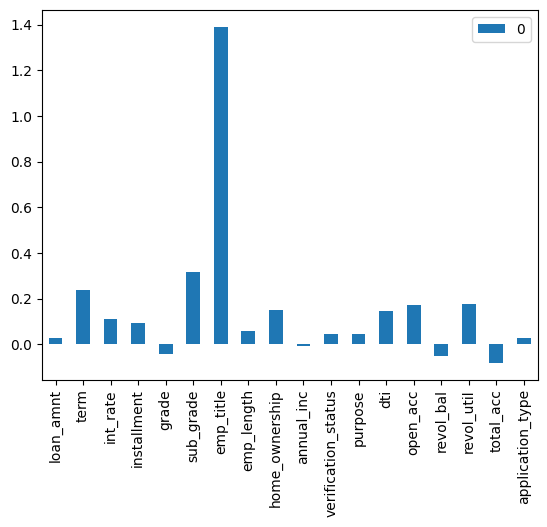

In [336]:
pd.DataFrame(data=LR_Std.coef_,columns=X.columns).T.plot(kind = "bar")

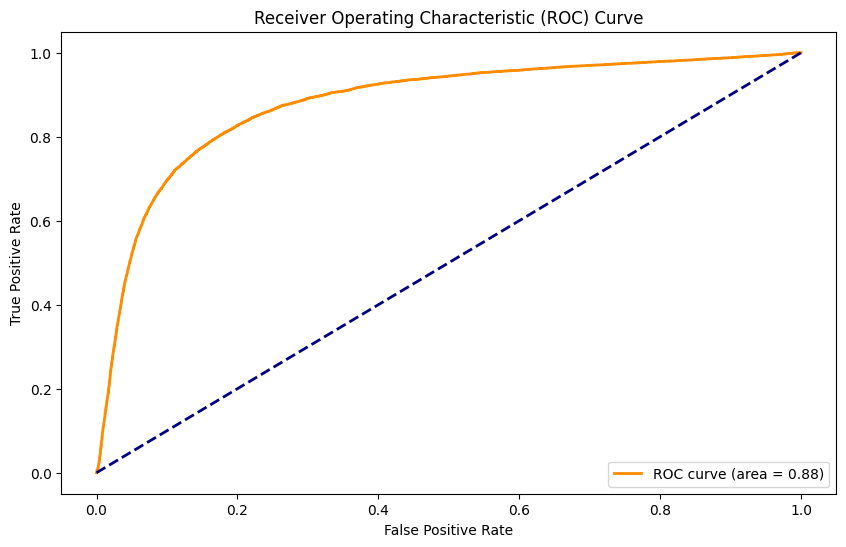

In [338]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Assuming you have already defined X_train, X_test, y_train, and y_test

# Fit logistic regression model
#model = LogisticRegression()

#model.fit(X_train, y_train)

# Predict probabilities for the positive class
y_prob = LR_Std.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


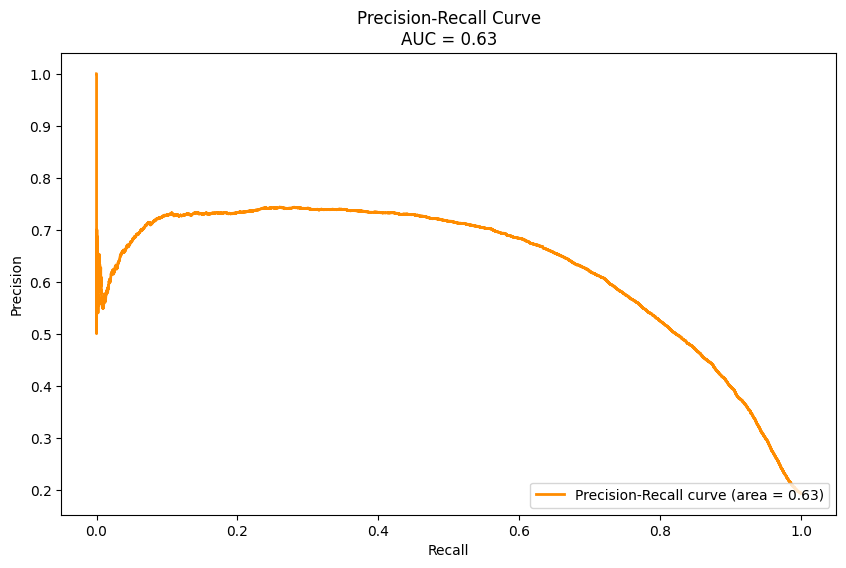

In [339]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc


# Predict probabilities for the positive class
y_prob = LR_Std.predict_proba(X_test)[:, 1]

# Compute Precision-Recall curve and AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (area = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve\nAUC = {:.2f}'.format(pr_auc))
plt.legend(loc='lower right')
plt.show()


In [340]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score


# Predict probabilities on the test set
y_prob = LR_Std.predict_proba(X_test)[:, 1]

# Set a threshold to classify predictions
threshold = 0.5  # You can adjust this threshold based on your needs

# Convert probabilities to binary predictions
y_pred = np.where(y_prob > threshold, 1, 0)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nAUC-ROC Score: {roc_auc}")



Confusion Matrix:
[[49297  2676]
 [ 5831  6534]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     51973
           1       0.71      0.53      0.61     12365

    accuracy                           0.87     64338
   macro avg       0.80      0.74      0.76     64338
weighted avg       0.86      0.87      0.86     64338


AUC-ROC Score: 0.8799069027326072


In [341]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score



# Predict probabilities on the test set
y_prob = LR_Std.predict_proba(X_test)[:, 1]

# Set a high threshold to classify predictions
high_threshold = 0.9  # You can adjust this threshold based on your risk tolerance

# Convert probabilities to binary predictions
y_pred = np.where(y_prob > high_threshold, 1, 0)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nAUC-ROC Score: {roc_auc}")


Confusion Matrix:
[[51730   243]
 [11894   471]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     51973
           1       0.66      0.04      0.07     12365

    accuracy                           0.81     64338
   macro avg       0.74      0.52      0.48     64338
weighted avg       0.78      0.81      0.74     64338


AUC-ROC Score: 0.8799069027326072


Data Balancing :

In [342]:
from imblearn.over_sampling import SMOTE

In [343]:
SmoteBL = SMOTE(k_neighbors=7)

In [344]:
X_smote , y_smote = SmoteBL.fit_resample(X_train,y_train)

In [345]:
X_smote.shape,  y_smote.shape

((416188, 18), (416188,))

In [346]:
LogReg = LogisticRegression(max_iter=1000,class_weight="balanced")

In [347]:
from sklearn.model_selection import cross_val_score

In [348]:
cross_val_score(estimator = LogReg,cv=5,X = X_smote,y = y_smote,scoring= "f1")



array([0.81026956, 0.81565796, 0.81849575, 0.82024092, 0.81783078])

In [349]:
cross_val_score(estimator = LogReg,cv=5,X = X_smote,y = y_smote,scoring= "precision")

array([0.83227359, 0.83406157, 0.8346028 , 0.83432747, 0.83208593])

In [350]:
cross_val_score(estimator = LogReg,cv=5,X = X_smote,y = y_smote,scoring= "accuracy")

array([0.81515654, 0.81963767, 0.82193229, 0.82322765, 0.82089696])

cross_val_score for train teast

In [351]:
cross_val_score(estimator = LogReg,cv=5,X = X_train,y = y_train,scoring= "precision")

array([0.53069755, 0.53775322, 0.53556687, 0.53524751, 0.52940374])

In [352]:
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression(max_iter=1000,class_weight="balanced")

In [353]:
LogReg.fit(X= X_train ,y = y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [354]:
LogReg.score(X_test,y_test)

0.826307936211881

In [355]:
LogReg.coef_.round(2)

array([[ 0.08,  0.22, -0.07,  0.05, -0.05,  0.53,  1.47,  0.05,  0.14,
         0.01,  0.06,  0.05,  0.17,  0.16, -0.06,  0.16, -0.07,  0.04]])

In [356]:
from sklearn.metrics  import confusion_matrix, f1_score, precision_score,recall_score
print(confusion_matrix(y_test, LogReg.predict(X_test)))
print(precision_score(y_test ,LogReg.predict(X_test)))
print(recall_score(y_test ,LogReg.predict(X_test)))
print(f1_score(y_test ,LogReg.predict(X_test)))

[[43363  8610]
 [ 2565  9800]]
0.532319391634981
0.7925596441568945
0.6368805848903332


In [357]:
LogReg.coef_

array([[ 0.07752502,  0.21645772, -0.07393633,  0.05412738, -0.04786132,
         0.53236815,  1.46811872,  0.05193312,  0.13760179,  0.01138659,
         0.05617464,  0.04580286,  0.16649176,  0.16001178, -0.05509122,
         0.15538849, -0.06998371,  0.03507524]])

In [358]:
df.drop(["loan_status"], axis = 1).columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'purpose', 'dti', 'open_acc', 'revol_bal',
       'revol_util', 'total_acc', 'application_type'],
      dtype='object')

In [359]:
feature_importance = pd.DataFrame(index = df.drop(["loan_status"],
                                                  axis = 1).columns,
                                  data = LogReg.coef_.ravel()).reset_index()
feature_importance

,index,0
0,loan_amnt,0.077525
1,term,0.216458
2,int_rate,-0.073936
3,installment,0.054127
4,grade,-0.047861
5,sub_grade,0.532368
6,emp_title,1.468119
7,emp_length,0.051933
8,home_ownership,0.137602
9,annual_inc,0.011387


<Axes: xlabel='0', ylabel='index'>

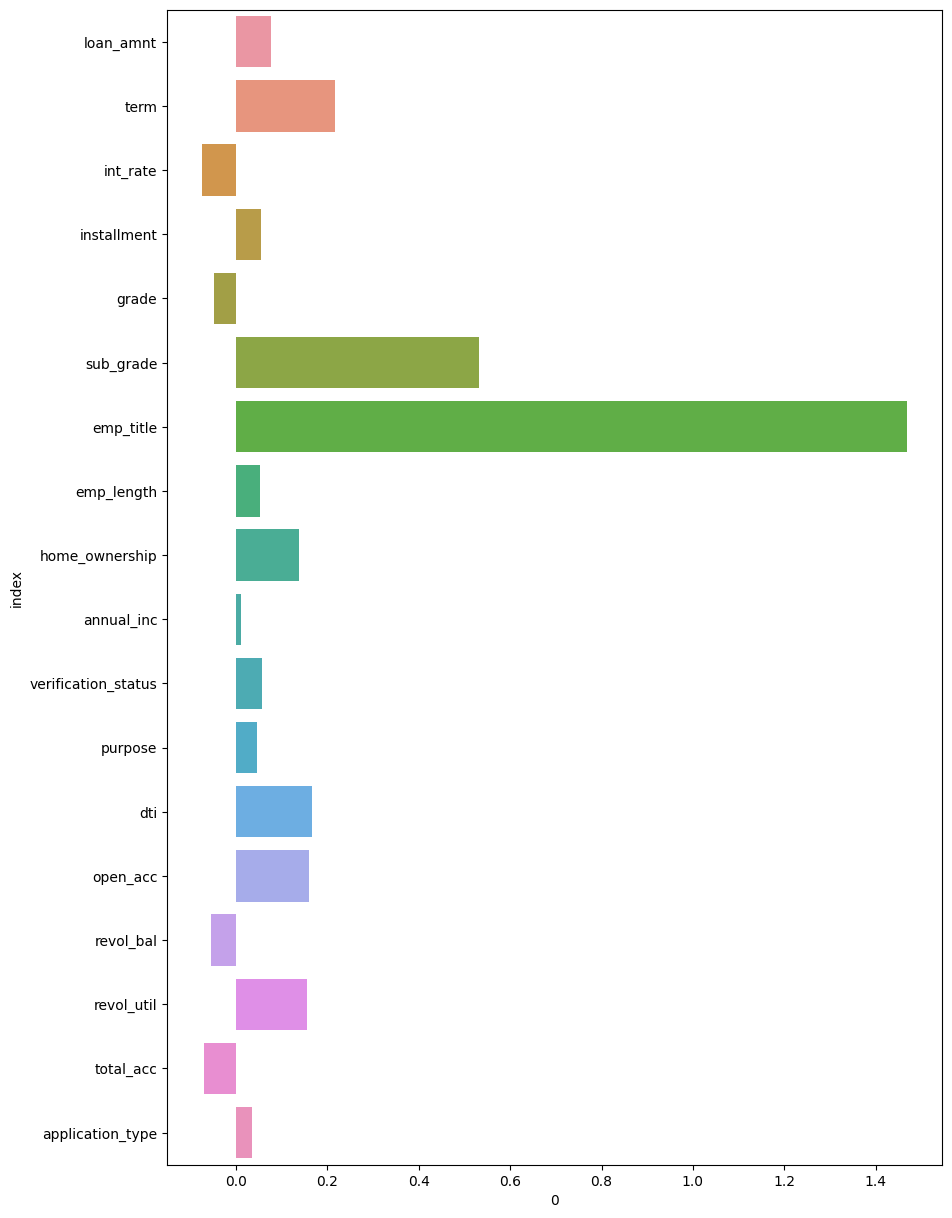

In [360]:
plt.figure(figsize=(10,15))
sns.barplot(y = feature_importance["index"],
           x =  feature_importance[0])

In [361]:
LogReg.score(X_train,y_train)

0.8278608898387411

<Axes: >

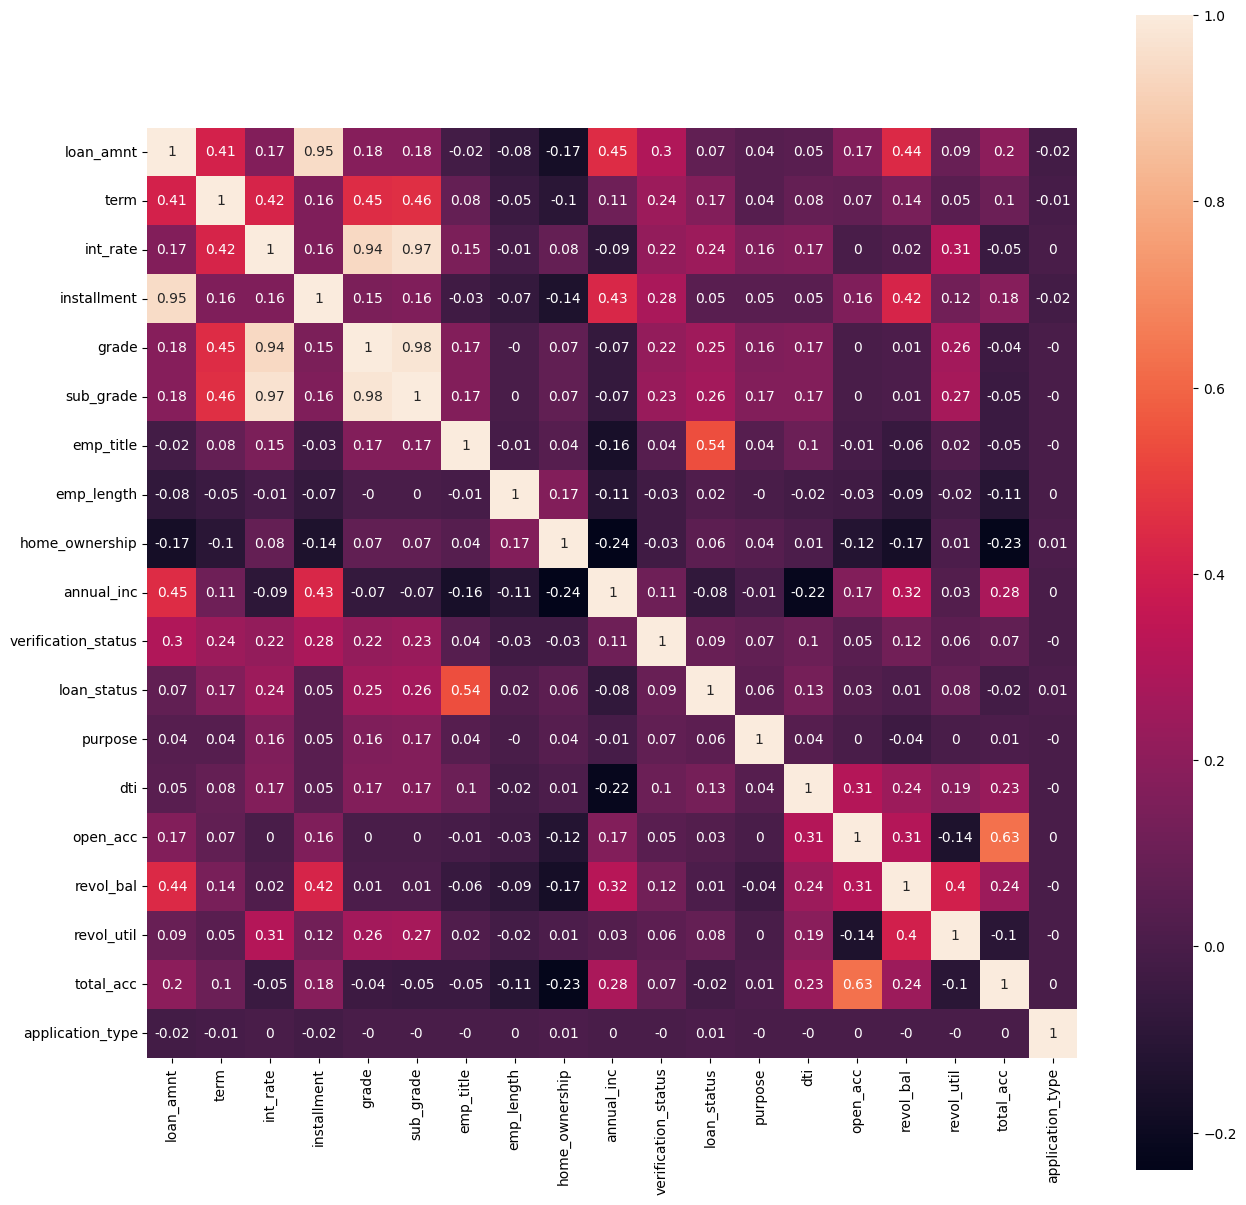

In [362]:
plt.figure(figsize=(15,15))

sns.heatmap(df.corr().round(2),annot=True,square=True)

In [399]:
from sklearn.metrics  import confusion_matrix, f1_score, precision_score,recall_score
confusion_matrix(y_test, LogReg.predict(X_test))

array([[43363,  8610],
       [ 2565,  9800]])

In [400]:
print("precision_score: ",precision_score(y_test ,LogReg.predict(X_test)))
print("recall_score: ",recall_score(y_test ,LogReg.predict(X_test)))

precision_score:  0.532319391634981
recall_score:  0.7925596441568945


In [401]:
pd.crosstab(y_test ,LogReg.predict(X_test))

col_0,0,1
loan_status,,
0,43363,8610
1,2565,9800


In [402]:
print("recall_score: ",recall_score(y_train ,LogReg.predict(X_train)))
print("recall_score: ",recall_score(y_test ,LogReg.predict(X_test)))
print("f1_score: ",f1_score(y_test ,LogReg.predict(X_test)))
print("f1_score: ",f1_score(y_train ,LogReg.predict(X_train)))

recall_score:  0.7932028585350008
recall_score:  0.7925596441568945
f1_score:  0.6368805848903332
f1_score:  0.6381901339431559


In [403]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score


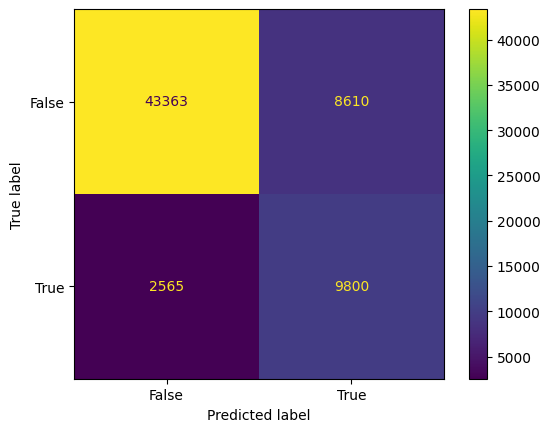

In [404]:
cm_display  = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test,
                                                          LogReg.predict(X_test)),display_labels=[False,True])
cm_display.plot()
plt.show()

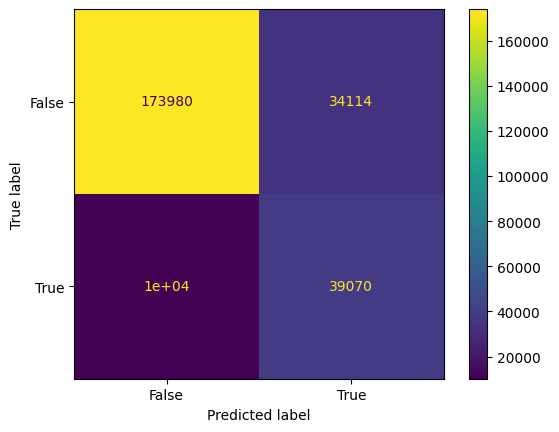

In [405]:
cm_display  = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_train,
                                                          LogReg.predict(X_train)),display_labels=[False,True])
cm_display.plot()
plt.show()

In [398]:
confusion_matrix = confusion_matrix(y_train,LogReg.predict(X_train))
confusion_matrix



array([[173980,  34114],
       [ 10186,  39070]])

DecisionTreeClassifier

In [370]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
DecisionTreeClassifier = DecisionTreeClassifier(max_depth=5, splitter="best",
                                               criterion="entropy",class_weight ="balanced")

In [ ]:
DecisionTreeClassifier.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5)

In [ ]:
DecisionTreeClassifier.score(X_test,y_test)

0.7946936491653456

 RandomForestClassifier

In [ ]:
# DecisionTreeClassifier.score(X_smote,y_smote)
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RF = RandomForestClassifier(n_estimators=30,max_depth=10,class_weight="balanced")

In [ ]:
RF.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=30)

In [ ]:
RF.score(X_test,y_test)

0.8081848985047717

In [ ]:
feature_importance = pd.DataFrame(index = df.drop(["loan_status"],
                                                  axis = 1).columns,
                                  data = RF.feature_importances_.ravel()).reset_index()
feature_importance

,index,0
0,loan_amnt,0.007487
1,term,0.015804
2,int_rate,0.069807
3,installment,0.007053
4,grade,0.036444
5,sub_grade,0.045008
6,emp_title,0.764041
7,emp_length,0.002034
8,home_ownership,0.003618
9,annual_inc,0.008325


<Axes: xlabel='0', ylabel='index'>

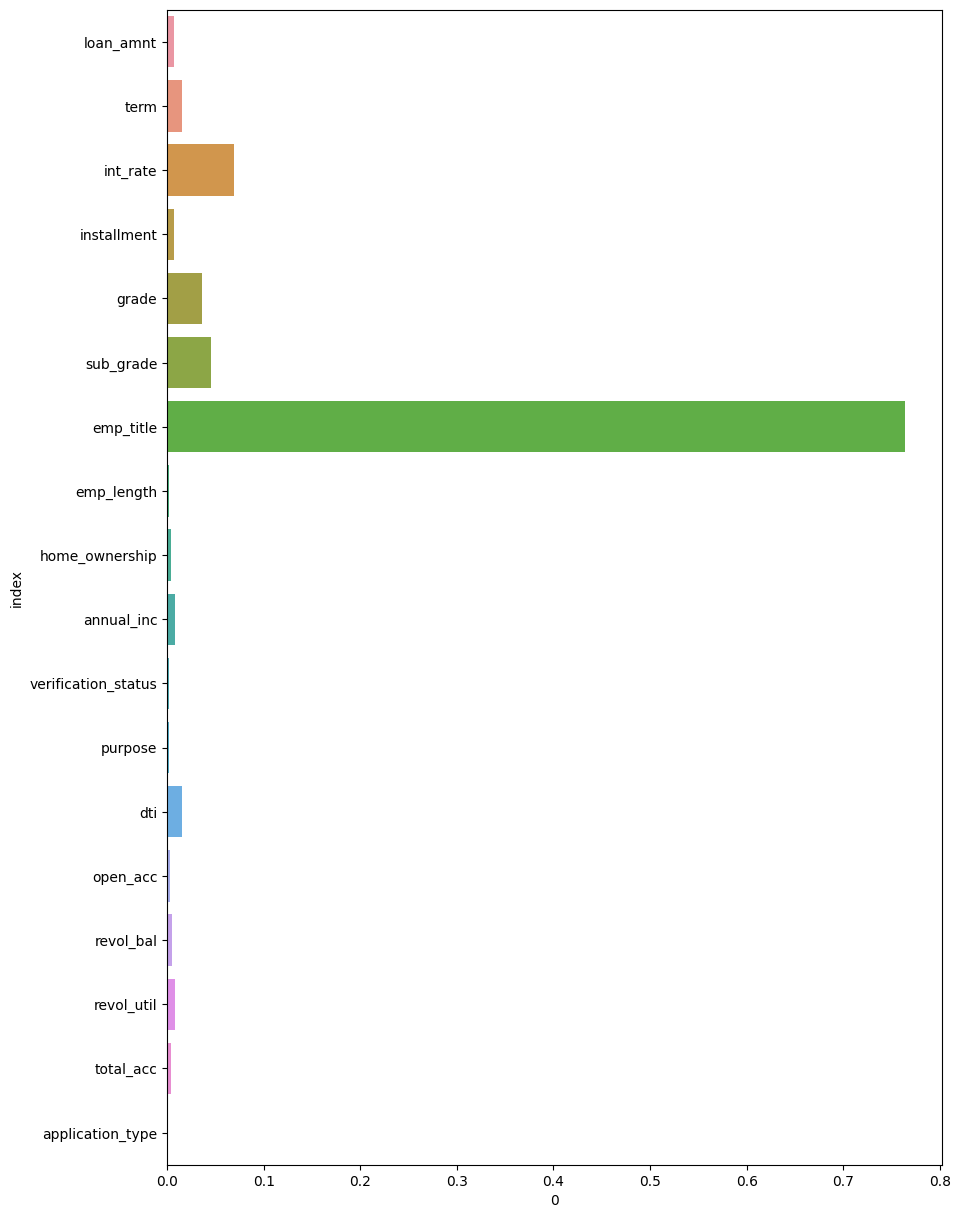

In [ ]:
plt.figure(figsize=(10,15))
sns.barplot(y = feature_importance["index"],
           x =  feature_importance[0])

In [ ]:
from sklearn.metrics import precision_recall_curve

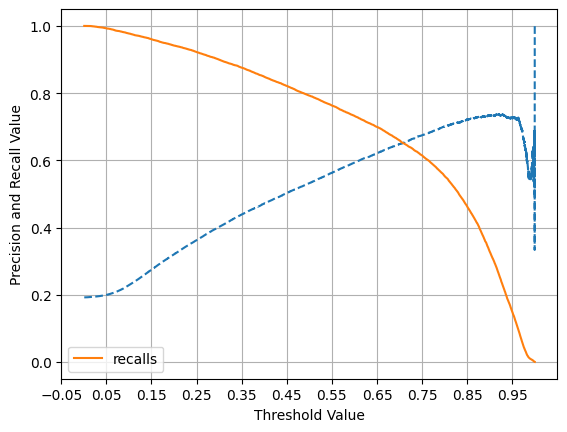

In [ ]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, LogReg.predict_proba(X_test)[:,1])

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve

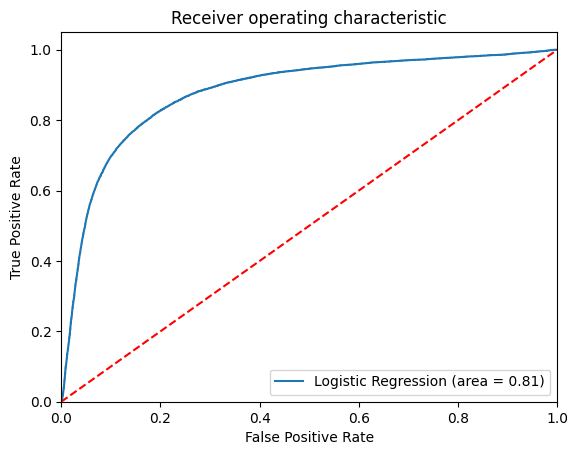

In [ ]:
logit_roc_auc = roc_auc_score(y_test, LogReg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, LogReg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
LogReg.predict_proba(X_test)

array([[0.73857178, 0.26142822],
       [0.85552479, 0.14447521],
       [0.53519655, 0.46480345],
       ...,
       [0.61316038, 0.38683962],
       [0.80044351, 0.19955649],
       [0.72890824, 0.27109176]])

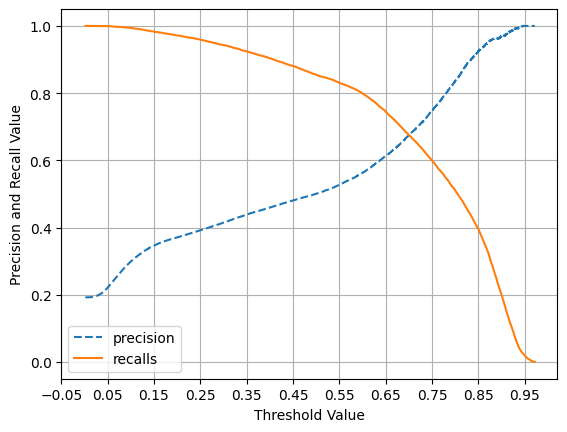

In [ ]:
precision_recall_curve_plot(y_test, RF.predict_proba(X_test)[:,1])

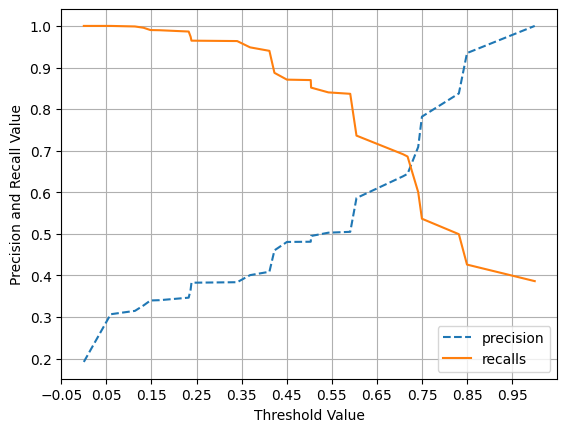

In [ ]:
precision_recall_curve_plot(y_test, DecisionTreeClassifier.predict_proba(X_test)[:,1])

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [ ]:
def custom_predict(X, threshold):
    probs = model.predict_proba(X)
    return (probs[:, 1] > threshold).astype(int)

In [ ]:
new_preds = custom_predict(X=X_test, threshold=0.75)

In [ ]:
model.score(X_test,y_test)

0.826307936211881

In [ ]:
precision_score(y_test,new_preds)

0.6748379074518164

# Inferences and Report :

* 396030 data points , 26 features , 1 label.

* 80% belongs to the class 0 : which is loan fully paid.

* 20% belongs to the class 1 : which were charged off.

* Loan Amount distribution / media is slightly higher for Charged_off loanStatus.

* Probability of CHarged_off status is higher in case of 60 month term.

* Interest Rate mean and media is higher for Charged_off LoanStatus.

* Probability of Charged_off LoanStatus is higher for Loan Grades are E ,F, G.

* G grade has the highest probability of having defaulter.

* Similar pattern is visible in sub_grades probability plot.

* Employement Length has overall same probability of Loan_status as fully paid and defaulter.

* That means Defaulters has no relation with their Emoployement length.

* For those borrowers who have rental home, has higher probability of defaulters.

* borrowers having their home mortgage and owns have lower probability of defaulter.

* Annual income median is lightly higher for those who's loan status is as fully paid.

* Somehow , verified income borrowers probability of defaulter is higher than those who are not verified by loan tap.

* Most of the borrowers take loans for dept-consolidation and credit card payoffs.

* the probability of defaulters is higher in the small_business owner borrowers.

* debt-to-income ratio is higher for defaulters.

* number of open credit lines in the borrowers credit file is same as for loan status as fully paid and defaulters.

* Number of derogatory public records increases , the probability of borrowers declared as defaulters also increases

* aspecially for those who have higher than 12 public_records.

* Total credit revolving balance is almost same for both borrowers who had fully paid loan and declared defaulter

* but Revolving line utilization rate is higher for defaulter borrowers.

* Application type Direct-Pay has higher probability of defaulter borrowers than individual and joint.

* Number of public record bankruptcies increasaes , higher the probability of defaulters.

* Most important features/ data for prediction , as per Logistic Regression, Decision tree classifier and Random Forest model are : Employee Title, Loan Grade and Sub-Grade, Interest rate and dept-to-income ratio.

# Actionable Insights & Recommendations

* We should try to keep the precision higher as possible compare to recall , and keep the false positive low.

* That will help not to missout the opportopportunity to finance more individuals and earn interest on it. This we can achieve by setting up the higher threshold.

* Giving loans to those even having slightly higher probability of defaulter, we can maximise the earning , by this risk taking method.

* Since NPA is a real problem in the industry , Company should more investigate and check for the proof of assets. Since it was observed in probability plot, verified borrowers had higher probability of defaulters than non-varified.

* Giving loans to those who have no mortgage house of any owned property have higher probability of defaulter , giving loan to this category borrowers can be a problem of NPA.